# Credit Risk Interpretability

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


In [2]:
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore')

In [ ]:
# realizamos la inportación de los métodos necesarios. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn import tree
from sklearn.tree import export_text
from sklearn.externals import joblib 
from xgboost import XGBClassifier
from subprocess import check_call
from IPython.display import Image as PImage

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras import metrics

import lime.lime_tabular
import shap


In [4]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

## 1. Tratamiento de datos

In [5]:
# lectura de datos.
df_heloc = pd.read_csv("./data/heloc_dataset_v1.csv")
df_heloc.shape

(10459, 24)

In [6]:
# descripción de los tipos de datos del fichero cargado.
df_heloc.dtypes

RiskPerformance                       object
ExternalRiskEstimate                   int64
MSinceOldestTradeOpen                  int64
MSinceMostRecentTradeOpen              int64
AverageMInFile                         int64
NumSatisfactoryTrades                  int64
NumTrades60Ever2DerogPubRec            int64
NumTrades90Ever2DerogPubRec            int64
PercentTradesNeverDelq                 int64
MSinceMostRecentDelq                   int64
MaxDelq2PublicRecLast12M               int64
MaxDelqEver                            int64
NumTotalTrades                         int64
NumTradesOpeninLast12M                 int64
PercentInstallTrades                   int64
MSinceMostRecentInqexcl7days           int64
NumInqLast6M                           int64
NumInqLast6Mexcl7days                  int64
NetFractionRevolvingBurden             int64
NetFractionInstallBurden               int64
NumRevolvingTradesWBalance             int64
NumInstallTradesWBalance               int64
NumBank2Na

In [7]:
# primeros datos del fichero.
df_heloc.head()

RiskPerformance  ExternalRiskEstimate  MSinceOldestTradeOpen  \
0             Bad                    55                    144   
1             Bad                    61                     58   
2             Bad                    67                     66   
3             Bad                    66                    169   
4             Bad                    81                    333   

   MSinceMostRecentTradeOpen  AverageMInFile  NumSatisfactoryTrades  \
0                          4              84                     20   
1                         15              41                      2   
2                          5              24                      9   
3                          1              73                     28   
4                         27             132                     12   

   NumTrades60Ever2DerogPubRec  NumTrades90Ever2DerogPubRec  \
0                            3                            0   
1                            4                            4   
2                            0                            0   
3                            1                            1   
4                            0                            0   

   PercentTradesNeverDelq  MSinceMostRecentDelq  ...  PercentInstallTrades  \
0                      83                     2  ...                    43   
1                     100                    -7  ...                    67   
2                     100                    -7  ...                    44   
3                      93                    76  ...                    57   
4                     100                    -7  ...                    25   

   MSinceMostRecentInqexcl7days  NumInqLast6M  NumInqLast6Mexcl7days  \
0                             0             0                      0   
1                             0             0                      0   
2                             0             4                      4   
3                             0             5                      4   
4                             0             1                      1   

   NetFractionRevolvingBurden  NetFractionInstallBurden  \
0                          33                        -8   
1                           0                        -8   
2                          53                        66   
3                          72                        83   
4                          51                        89   

   NumRevolvingTradesWBalance  NumInstallTradesWBalance  \
0                           8                         1   
1                           0                        -8   
2                           4                         2   
3                           6                         4   
4                           3                         1   

   NumBank2NatlTradesWHighUtilization  PercentTradesWBalance  
0                                   1                     69  
1                                  -8                      0  
2                                   1                     86  
3                                   3                     91  
4                                   0                     80  

[5 rows x 24 columns]

In [8]:
# descripción de los datos con información para cada característica.
df_heloc.describe()

ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentTradeOpen  \
count          10459.000000           10459.000000               10459.000000   
mean              67.425758             184.205373                   8.543455   
std               21.121621             109.683816                  13.301745   
min               -9.000000              -9.000000                  -9.000000   
25%               63.000000             118.000000                   3.000000   
50%               71.000000             178.000000                   5.000000   
75%               79.000000             249.500000                  11.000000   
max               94.000000             803.000000                 383.000000   

       AverageMInFile  NumSatisfactoryTrades  NumTrades60Ever2DerogPubRec  \
count    10459.000000           10459.000000                 10459.000000   
mean        73.843293              19.428052                     0.042738   
std         38.782803              13.004327                     2.513910   
min         -9.000000              -9.000000                    -9.000000   
25%         52.000000              12.000000                     0.000000   
50%         74.000000              19.000000                     0.000000   
75%         95.000000              27.000000                     1.000000   
max        383.000000              79.000000                    19.000000   

       NumTrades90Ever2DerogPubRec  PercentTradesNeverDelq  \
count                 10459.000000            10459.000000   
mean                     -0.142843               86.661536   
std                       2.367397               25.999584   
min                      -9.000000               -9.000000   
25%                       0.000000               87.000000   
50%                       0.000000               96.000000   
75%                       0.000000              100.000000   
max                      19.000000              100.000000   

       MSinceMostRecentDelq  MaxDelq2PublicRecLast12M  ...  \
count          10459.000000              10459.000000  ...   
mean               6.762406                  4.928291  ...   
std               20.501250                  3.756275  ...   
min               -9.000000                 -9.000000  ...   
25%               -7.000000                  4.000000  ...   
50%               -7.000000                  6.000000  ...   
75%               14.000000                  7.000000  ...   
max               83.000000                  9.000000  ...   

       PercentInstallTrades  MSinceMostRecentInqexcl7days  NumInqLast6M  \
count          10459.000000                  10459.000000  10459.000000   
mean              32.166460                     -0.325366      0.868152   
std               20.128634                      6.067556      3.179304   
min               -9.000000                     -9.000000     -9.000000   
25%               20.000000                     -7.000000      0.000000   
50%               31.000000                      0.000000      1.000000   
75%               44.000000                      1.000000      2.000000   
max              100.000000                     24.000000     66.000000   

       NumInqLast6Mexcl7days  NetFractionRevolvingBurden  \
count           10459.000000                10459.000000   
mean                0.812602                   31.629888   
std                 3.143698                   30.060140   
min                -9.000000                   -9.000000   
25%                 0.000000                    5.000000   
50%                 1.000000                   25.000000   
75%                 2.000000                   54.000000   
max                66.000000                  232.000000   

       NetFractionInstallBurden  NumRevolvingTradesWBalance  \
count              10459.000000                10459.000000   
mean                  39.158906                    3.185008   
std                   42.101601                    4.413173

### 1.1. Datos faltantes

In [9]:
# se comprueba si hay alguna característica con valores faltantes NaN
df_heloc.isnull().sum()

RiskPerformance                       0
ExternalRiskEstimate                  0
MSinceOldestTradeOpen                 0
MSinceMostRecentTradeOpen             0
AverageMInFile                        0
NumSatisfactoryTrades                 0
NumTrades60Ever2DerogPubRec           0
NumTrades90Ever2DerogPubRec           0
PercentTradesNeverDelq                0
MSinceMostRecentDelq                  0
MaxDelq2PublicRecLast12M              0
MaxDelqEver                           0
NumTotalTrades                        0
NumTradesOpeninLast12M                0
PercentInstallTrades                  0
MSinceMostRecentInqexcl7days          0
NumInqLast6M                          0
NumInqLast6Mexcl7days                 0
NetFractionRevolvingBurden            0
NetFractionInstallBurden              0
NumRevolvingTradesWBalance            0
NumInstallTradesWBalance              0
NumBank2NatlTradesWHighUtilization    0
PercentTradesWBalance                 0
dtype: int64

Ninguna columna tiene valores nulos, aunque se observa que en todas las columnas salvo la característica a predecir se tiene el valor mínimo de -9

**Tratamiento de valores especiales**  


Según la documentación hay tres valores especiales:  
-9 No Bureau Record or No Investigation  
-8 No Usable/Valid Trades or Inquiries  
-7 Condition not Met (e.g. No Inquiries, No Delinquencies)  



**Tratamiento para los valores -9**  
Existen 588 registros que tienen todos los valores a -9. Dado que todas las características son no válidadas, se eliminan.


In [10]:
x_col = df_heloc.columns.values
# columnas con valores -9
for col in x_col:
    if list(df_heloc[col].isin([-9])).count(True)>0:
        print(list(df_heloc[col].isin([-9])).count(True),col)

598 ExternalRiskEstimate
588 MSinceOldestTradeOpen
588 MSinceMostRecentTradeOpen
588 AverageMInFile
588 NumSatisfactoryTrades
588 NumTrades60Ever2DerogPubRec
588 NumTrades90Ever2DerogPubRec
588 PercentTradesNeverDelq
588 MSinceMostRecentDelq
588 MaxDelq2PublicRecLast12M
588 MaxDelqEver
588 NumTotalTrades
588 NumTradesOpeninLast12M
588 PercentInstallTrades
588 MSinceMostRecentInqexcl7days
588 NumInqLast6M
588 NumInqLast6Mexcl7days
588 NetFractionRevolvingBurden
588 NetFractionInstallBurden
588 NumRevolvingTradesWBalance
588 NumInstallTradesWBalance
588 NumBank2NatlTradesWHighUtilization
588 PercentTradesWBalance


In [11]:
# Tratamiento de los valores -9
# para aquellos datos cuyo valor sera -9 se consideran como NaN 
# después se borran los registros que tengan todas las columnas datos NaN
df_heloc = df_heloc.replace([-9], np.nan)
df_heloc[df_heloc.isnull().sum(axis=1)>22]


RiskPerformance  ExternalRiskEstimate  MSinceOldestTradeOpen  \
55               Good                   NaN                    NaN   
64               Good                   NaN                    NaN   
66               Good                   NaN                    NaN   
67                Bad                   NaN                    NaN   
70               Good                   NaN                    NaN   
...               ...                   ...                    ...   
10418            Good                   NaN                    NaN   
10420             Bad                   NaN                    NaN   
10421            Good                   NaN                    NaN   
10432            Good                   NaN                    NaN   
10437            Good                   NaN                    NaN   

       MSinceMostRecentTradeOpen  AverageMInFile  NumSatisfactoryTrades  \
55                           NaN             NaN                    NaN   
64                           NaN             NaN                    NaN   
66                           NaN             NaN                    NaN   
67                           NaN             NaN                    NaN   
70                           NaN             NaN                    NaN   
...                          ...             ...                    ...   
10418                        NaN             NaN                    NaN   
10420                        NaN             NaN                    NaN   
10421                        NaN             NaN                    NaN   
10432                        NaN             NaN                    NaN   
10437                        NaN             NaN                    NaN   

       NumTrades60Ever2DerogPubRec  NumTrades90Ever2DerogPubRec  \
55                             NaN                          NaN   
64                             NaN                          NaN   
66                             NaN                          NaN   
67                             NaN                          NaN   
70                             NaN                          NaN   
...                            ...                          ...   
10418                          NaN                          NaN   
10420                          NaN                          NaN   
10421                          NaN                          NaN   
10432                          NaN                          NaN   
10437                          NaN                          NaN   

       PercentTradesNeverDelq  MSinceMostRecentDelq  ...  \
55                        NaN                   NaN  ...   
64                        NaN                   NaN  ...   
66                        NaN                   NaN  ...   
67                        NaN                   NaN  ...   
70                        NaN                   NaN  ...   
...                       ...                   ...  ...   
10418                     NaN                   NaN  ...   
10420                     NaN                   NaN  ...   
10421                     NaN                   NaN  ...   
10432                     NaN                   NaN  ...   
10437                     NaN                   NaN  ...   

       PercentInstallTrades  MSinceMostRecentInqexcl7days  NumInqLast6M  \
55                      NaN                           NaN           NaN   
64                      NaN                           NaN           NaN   
66                      NaN                           NaN           NaN   
67                      NaN                           NaN           NaN   
70                      NaN                           NaN           NaN   
...                     ...                           ...           ...   
10418                   NaN                           NaN           NaN   
10420                   NaN                           NaN           NaN   
10421                   NaN                           NaN      

In [12]:
# se eliminan los 588 registros con todos los valores a nulos
df_heloc = df_heloc.dropna(thresh=2)
df_heloc.shape

(9871, 24)

In [13]:
# después de eliminar los registros existen 10 registros cuyo valor en ExternalRiskEstimate era -9
# dos de ellos con la etiqueta 'Good' y el resto con la etiqueta 'Bad'
df_heloc[df_heloc.ExternalRiskEstimate.isnull()]['RiskPerformance']

89      Good
639      Bad
2662     Bad
4133     Bad
6522     Bad
7851     Bad
8721     Bad
8771     Bad
8921    Good
9176     Bad
Name: RiskPerformance, dtype: object

In [14]:
# se reemplaza de nuevo el valor nulo por el -9.
df_heloc = df_heloc.replace(np.nan,-9)


**Tratamiento para los valores -7**  


Existen dos columnas con valores -7 en sus datos:  


In [15]:
# columnas con valores -7
for col in x_col:
    if list(df_heloc[col].isin([-7])).count(True)>0:
        print(list(df_heloc[col].isin([-7])).count(True),col)

4664 MSinceMostRecentDelq
1855 MSinceMostRecentInqexcl7days



Según la definición del valor -7 correspondería que no hay valores definidos.  
No seería correcto sustituir el valor por 0 porque, al ser número de meses de esa condición, se estaría dando un valor erróneo. Al igual que si se sustituye por la media o la mediana, correspondería a valores no correctos para ese dato.

Por lo tanto se mantiene el valor -7


**Tratamiento para los valores -8**  
Las  columnas para las que existen valores -8 serían: 


In [16]:
# columnas con valores -8
for col in x_col:
    if list(df_heloc[col].isin([-8])).count(True)>0:
        print(list(df_heloc[col].isin([-8])).count(True), col)

239 MSinceOldestTradeOpen
176 MSinceMostRecentDelq
476 MSinceMostRecentInqexcl7days
186 NetFractionRevolvingBurden
3419 NetFractionInstallBurden
156 NumRevolvingTradesWBalance
861 NumInstallTradesWBalance
583 NumBank2NatlTradesWHighUtilization
18 PercentTradesWBalance


In [17]:
# número de registros con la característica NetFractionRevolvingBurden a cero
df_heloc.query('NetFractionRevolvingBurden==0')['NetFractionRevolvingBurden'].value_counts() 

0.0    608
Name: NetFractionRevolvingBurden, dtype: int64

In [18]:
# número de registros con la característica NetFractionInstallBurden a cero
df_heloc.query('NetFractionInstallBurden==0')['NetFractionInstallBurden'].value_counts() 

0.0    10
Name: NetFractionInstallBurden, dtype: int64

In [19]:
# número de registros con la característica NumRevolvingTradesWBalance a cero
df_heloc.query('NumRevolvingTradesWBalance==0')['NumRevolvingTradesWBalance'].value_counts() 

0.0    304
Name: NumRevolvingTradesWBalance, dtype: int64

In [20]:
# número de registros con la característica NumBank2NatlTradesWHighUtilization a cero
df_heloc.query('NumBank2NatlTradesWHighUtilization==0')['NumBank2NatlTradesWHighUtilization'].value_counts() 

0.0    4308
Name: NumBank2NatlTradesWHighUtilization, dtype: int64

Igual que para el caso de -7, en las columnas de meses no aplica poner un valor 0 y para el resto, correspondientes a saldos  número de operaciones ya existen registros con valor 0 por lo que también se estaría dando un valor erróneo para esos casos.  
Se mantiene el valor -8

### 1.2. Presentación de datos

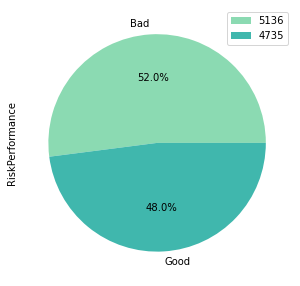

In [21]:
# Se muestra el porcentaje de la muestra para cada una de los dos valores target
color=sns.color_palette("mako_r")
df_heloc['RiskPerformance'].value_counts().plot(kind='pie',colors=color,autopct='%1.1f%%',figsize=(5,5))
plt.show
varValue = df_heloc.RiskPerformance.value_counts()
plt.legend(list(varValue))
plt.show()

In [22]:
# La variable de destino para predecir es una variable binaria llamada RiskPerformance. 
# El valor Bad indica que un consumidor tenía 90 días de atraso o peor al menos una vez 
# durante un período de 24 meses desde que se abrió la cuenta de crédito. 
# El valor Good indica que han realizado sus pagos sin haber tenido más de 90 días de atraso.
# Se actualiza los valores sustituyendo Bad con el valor 1 y Good con el valor 0
df_heloc.RiskPerformance = df_heloc.RiskPerformance.replace({"Bad": 1, "Good": 0})

In [23]:
# se actualiza la descripción de los datos con el cambio realizado en la columna target
df_heloc.describe()

RiskPerformance  ExternalRiskEstimate  MSinceOldestTradeOpen  \
count      9871.000000           9871.000000            9871.000000   
mean          0.520312             71.978320             195.714315   
std           0.499613             10.198244             101.936102   
min           0.000000             -9.000000              -8.000000   
25%           0.000000             64.000000             131.000000   
50%           1.000000             72.000000             183.000000   
75%           1.000000             80.000000             255.000000   
max           1.000000             94.000000             803.000000   

       MSinceMostRecentTradeOpen  AverageMInFile  NumSatisfactoryTrades  \
count                9871.000000     9871.000000            9871.000000   
mean                    9.588492       78.778138              21.121467   
std                    12.963398       34.066063              11.321396   
min                     0.000000        4.000000               0.000000   
25%                     3.000000       57.000000              13.000000   
50%                     6.000000       76.000000              20.000000   
75%                    12.000000       97.000000              28.000000   
max                   383.000000      383.000000              79.000000   

       NumTrades60Ever2DerogPubRec  NumTrades90Ever2DerogPubRec  \
count                  9871.000000                  9871.000000   
mean                      0.581400                     0.384763   
std                       1.238783                     0.993223   
min                       0.000000                     0.000000   
25%                       0.000000                     0.000000   
50%                       0.000000                     0.000000   
75%                       1.000000                     0.000000   
max                      19.000000                    19.000000   

       PercentTradesNeverDelq  MSinceMostRecentDelq  ...  \
count             9871.000000           9871.000000  ...   
mean                92.359943              7.701347  ...   
std                 11.772876             20.728177  ...   
min                  0.000000             -8.000000  ...   
25%                 89.000000             -7.000000  ...   
50%                 97.000000              0.000000  ...   
75%                100.000000             15.000000  ...   
max                100.000000             83.000000  ...   

       PercentInstallTrades  MSinceMostRecentInqexcl7days  NumInqLast6M  \
count           9871.000000                   9871.000000   9871.000000   
mean              34.618681                      0.191369      1.455982   
std               17.953432                      5.853077      2.136161   
min                0.000000                     -8.000000      0.000000   
25%               21.000000                      0.000000      0.000000   
50%               33.000000                      0.000000      1.000000   
75%               45.000000                      1.000000      2.000000   
max              100.000000                     24.000000     66.000000   

       NumInqLast6Mexcl7days  NetFractionRevolvingBurden  \
count            9871.000000                 9871.000000   
mean                1.397123                   34.050147   
std                 2.096102                   29.210292   
min                 0.000000                   -8.000000   
25%                 0.000000                    8.000000   
50%                 1.000000                   28.000000   
75%                 2.000000                   56.000000   
max                66.000000                  232.000000   

       NetFractionInstallBurden  NumRevolvingTradesWBalance  \
count               9871.000000                 9871.000000   
mean                  42.027657                    3.910850   
std                   41.614214                    3.356217   
min                   -8.000000                   -8.000000   
25%           

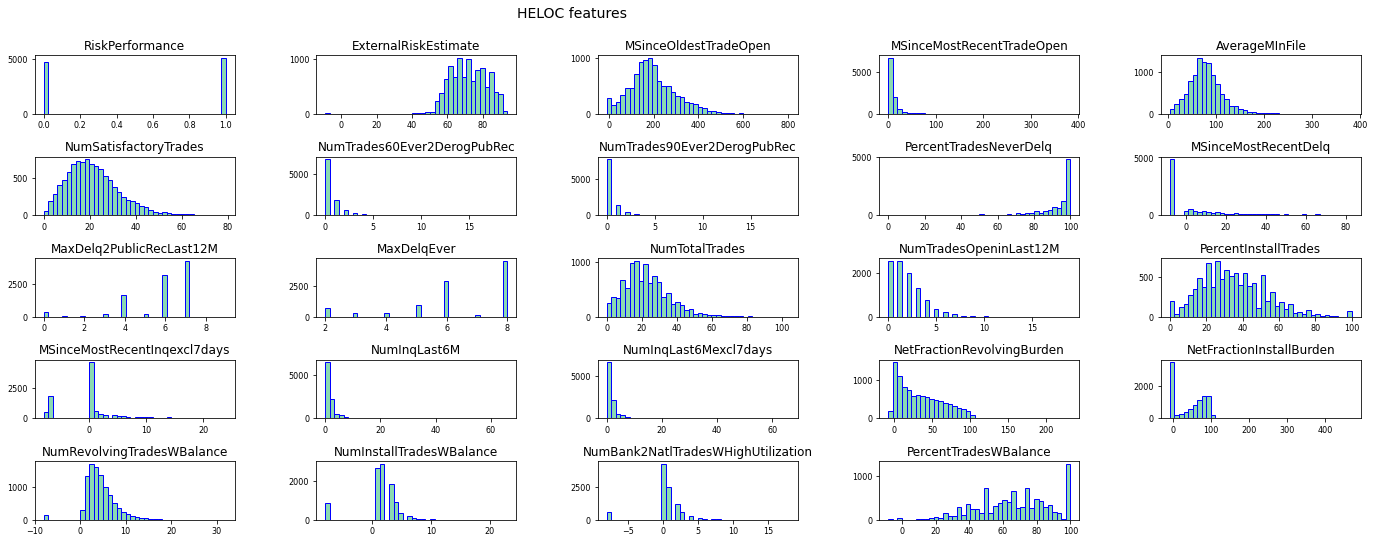

In [24]:
# Se muestra información de la distribución de las distintas características.
df_heloc[x_col].hist(bins=40, edgecolor='b', linewidth=1.0,
                          xlabelsize=8, ylabelsize=8, grid=False, 
                          figsize=(16,6), color=color[0])    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('HELOC features', x=0.50, y=1.25, fontsize=14);  

### 1.3. Datos categóricos

Existen dos características categórizas:  
- MaxDelq2PublicRecLast12M: período de morosidad más largo de los últimos 12 meses.
- MaxDelqEver: período de morosidad más largo

Las categorías de estas características están relacionados aunque los valores en cada una de ellas difiere, para el mismo concepto, el código asignado en cada característica es distinto.   
Se adaptan los códigos de la categoría MaxDelq2PublicRecLast12M con los códigos de la categoría MaxDelqEver para unificar ambas características.  


|   valor  |  significado     |  transformación en MaxDelq2PublicRecLast12M    |
|:------   |:------|:------|
|   **1**  | No hay tal valor       | -   |
|   **2**  | comentario negativo    | 0 -->2  |
|   **3**  | 120+ días de morosidad | 1 -->3   |
|   **4**  |  90 días de retraso    | 2 -->4   |
|   **5**  |  60 días de retraso    | 3 -->5   |
|   **6**  |  30 días de retraso    | 4 -->6   |
|   **7**  |  morosidad desconocida | 5,6 -->7 |
|   **8**  |  actual y nunca moroso | 7 -->8   |
|   **9**  |  todos los demás       | 8,9 -->9 |


In [25]:
# Se muestran el número de registro de la característica MaxDelq2PublicRecLast12M, 
# tanto para la etiqueta 0 como para 1, para cada categoría
pd.crosstab(index=df_heloc.RiskPerformance,columns=df_heloc.MaxDelq2PublicRecLast12M, margins=True)

MaxDelq2PublicRecLast12M  0.0  1.0  2.0  3.0   4.0  5.0   6.0   7.0  9.0   All
RiskPerformance                                                               
0                          91   20   15   68   434   65  1429  2611    2  4735
1                         245   34   38  156  1178  171  1698  1612    4  5136
All                       336   54   53  224  1612  236  3127  4223    6  9871

In [26]:
# Se muestran el número de registro de la característica MaxDelqEver
# tanto para la etiqueta 0 como para 1, para cada categoría
pd.crosstab(index=df_heloc.RiskPerformance,columns=df_heloc.MaxDelqEver, margins=True)

MaxDelqEver      2.0  3.0  4.0  5.0   6.0  7.0   8.0   All
RiskPerformance                                           
0                222  117  105  333  1154   76  2728  4735
1                517  194  216  635  1714   56  1804  5136
All              739  311  321  968  2868  132  4532  9871

In [27]:
# los valores tanto de MaxDelqEvercomo de MaxDelq2PublicRecLast12M son enteros categóricos 
# se hace la conversión de MaxDelqEver a enteros y la de MaxDelq2PublicRecLast12M según la tabla de equivalencias anterior
df_heloc.MaxDelqEver = df_heloc.MaxDelqEver.astype(int)
df_heloc.MaxDelq2PublicRecLast12M = df_heloc.MaxDelq2PublicRecLast12M.map({0:2,
                                                                           1:3,
                                                                           2:4,
                                                                           3:5,
                                                                           4:6,
                                                                           5:7, # tanto el valor 5 como el 6 se
                                                                           6:7, # transforman en el valor 7
                                                                           7:8, 
                                                                           8:9, # tanto el valor 8 como el 9 se
                                                                           9:9},# transforman en el valor 9 
                                                                            na_action=None)

In [28]:
# Se muestran los resultados de la transformación para MaxDelq2PublicRecLast12M
pd.crosstab(index=df_heloc.RiskPerformance,columns=df_heloc.MaxDelq2PublicRecLast12M,margins=True)

MaxDelq2PublicRecLast12M    2   3   4    5     6     7     8  9   All
RiskPerformance                                                      
0                          91  20  15   68   434  1494  2611  2  4735
1                         245  34  38  156  1178  1869  1612  4  5136
All                       336  54  53  224  1612  3363  4223  6  9871

In [29]:
# Se muestran los resultados de la transformación para MaxDelqEver
pd.crosstab(index=df_heloc.RiskPerformance,columns=df_heloc.MaxDelqEver,margins=True)

MaxDelqEver        2    3    4    5     6    7     8   All
RiskPerformance                                           
0                222  117  105  333  1154   76  2728  4735
1                517  194  216  635  1714   56  1804  5136
All              739  311  321  968  2868  132  4532  9871

In [30]:
# Se construye tablas cruzadas sin los totales y por porcentajes
# para cada una de las características para poder mostrar los datos en gráfica
md12M = pd.crosstab(index=df_heloc.RiskPerformance,
                    columns=df_heloc.MaxDelq2PublicRecLast12M).apply(lambda r: r/len(df_heloc) *100,axis=1)
stacked12M = md12M.stack().reset_index().rename(columns={0:'percentage'})
md = pd.crosstab(index=df_heloc.RiskPerformance,
                 columns=df_heloc.MaxDelqEver).apply(lambda r: r/len(df_heloc) *100,axis=1)
stackedmd = md.stack().reset_index().rename(columns={0:'percentage'})

Text(0.5, 1.0, 'Período de morosidad más largo')

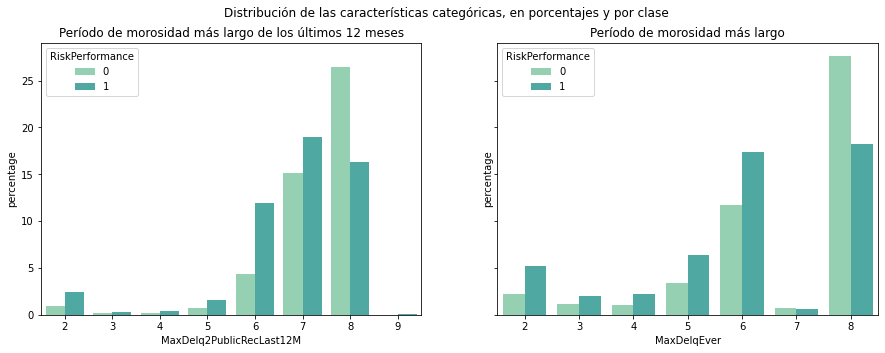

In [31]:
# Se muestra la gráfica de ambas distribuciones agrupada por el valor de la característica target
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Distribución de las características categóricas, en porcentajes y por clase')
sns.barplot(ax=axes[0], x=stacked12M.MaxDelq2PublicRecLast12M, y=stacked12M.percentage, 
            hue=stacked12M.RiskPerformance, palette=color)
axes[0].set_title('Período de morosidad más largo de los últimos 12 meses')

sns.barplot(ax=axes[1], x=stackedmd.MaxDelqEver, y=stackedmd.percentage, 
            hue=stackedmd.RiskPerformance,palette=color)
axes[1].set_title('Período de morosidad más largo')

In [32]:
# comparativa de los valores de la variable categórica MaxDelq2PublicRecLast12M en relación a cada valor de target 

pd.crosstab(index=df_heloc.RiskPerformance,columns=df_heloc.MaxDelq2PublicRecLast12M,
            margins=True).apply(lambda r: r/len(df_heloc) *100,axis=1)


MaxDelq2PublicRecLast12M         2         3         4         5          6  \
RiskPerformance                                                               
0                         0.921892  0.202614  0.151960  0.688887   4.396718   
1                         2.482018  0.344443  0.384966  1.580387  11.933948   
All                       3.403910  0.547057  0.536926  2.269274  16.330666   

MaxDelq2PublicRecLast12M          7          8         9         All  
RiskPerformance                                                       
0                         15.135245  26.451221  0.020261   47.968797  
1                         18.934252  16.330666  0.040523   52.031203  
All                       34.069497  42.781886  0.060784  100.000000

Los máximos porcentajes corresponden a los valores 8, actual y nunca moroso y 7, morosidad desconocida, con un 42,8% y 34% respectivamente.  
Para el valor 7 la proporción es similar a la proporción de la muestra origina respecto al target, 45% del 0 frente a 55% del 1.  
Para el valor 8, el 61% corresponde al target 0 y el 39% al target 1, lo cual está alineado con el sentido del atributo, que implica que el cliente no es moroso, con lo que tendría más posibilidad de concederse la línea de crédito. 

In [33]:
# comparativa de los valores de la variable categórica MaxDelqEver en relación a cada valor de target 

pd.crosstab(index=df_heloc.RiskPerformance,columns=df_heloc.MaxDelqEver,
            margins=True).apply(lambda r: r/len(df_heloc) *100,axis=1)


MaxDelqEver             2         3         4         5          6         7  \
RiskPerformance                                                                
0                2.249012  1.185290  1.063722  3.373518  11.690811  0.769932   
1                5.237565  1.965353  2.188228  6.432986  17.363996  0.567318   
All              7.486577  3.150643  3.251950  9.806504  29.054807  1.337251   

MaxDelqEver              8         All  
RiskPerformance                         
0                27.636511   47.968797  
1                18.275757   52.031203  
All              45.912268  100.000000

Los máximos porcentajes corresponden a los valores 8, actual y nunca moroso y 6, 30 días de retraso, con un 45.9% y 29% respectivamente.  
Para el valor 8, el 60% corresponde al target 0 y el 40% al target 1, que igualmente está alineado con el sentido de la categoría 8, que indica que los clientes no son morosos.  
Para el valore 6, el 40% corresponde al target 0 y el 60% al target 1, que corresponde con los porcentajes de la muestra en cada una de las etiquetas, lo que indicaría que está igualmente repartido los porcentajes de clientes con 30 días de morosidad.  
Para valores de MaxDelqEver menores de 6 el target predominante es 1, lo cual se explicaría ya que a mayor morosidad, mayor es la probabilidad de que no cumpla con los pagos en la línea de crédito.

**Transformamos las variables categóricas auto-encoder**  


In [34]:
# Las dos características categóricas se convierten en variables dummys para la interpretabilidad de las mismas
# para realizarlo se define la función prepare_inputs que crea una característica dummys por categoría
# y elimina las cartegorías de partida
def prepare_inputs(X_enc, categorical_feature):
    dummy = pd.get_dummies(X_enc[categorical_feature], columns = categorical_feature)
    X_enc = X_enc.merge(dummy, left_index= True, right_index= True)
    X_enc.drop(categorical_feature,axis=1, inplace=True)

    return X_enc

In [35]:
# se genera un nuevo DataFrame como copia de los datos originales sobre el que se trabaja para incluir las nuevas
# categorías dummy y eliminar las originales categóricas
X_enc = df_heloc.copy()
X_enc = prepare_inputs(X_enc, categorical_feature = ['MaxDelq2PublicRecLast12M', 'MaxDelqEver'])
print('Dimensión final del dataset ', X_enc.shape)
X_enc.head()

Dimensión final del dataset  (9871, 37)


RiskPerformance  ExternalRiskEstimate  MSinceOldestTradeOpen  \
0                1                  55.0                  144.0   
1                1                  61.0                   58.0   
2                1                  67.0                   66.0   
3                1                  66.0                  169.0   
4                1                  81.0                  333.0   

   MSinceMostRecentTradeOpen  AverageMInFile  NumSatisfactoryTrades  \
0                        4.0            84.0                   20.0   
1                       15.0            41.0                    2.0   
2                        5.0            24.0                    9.0   
3                        1.0            73.0                   28.0   
4                       27.0           132.0                   12.0   

   NumTrades60Ever2DerogPubRec  NumTrades90Ever2DerogPubRec  \
0                          3.0                          0.0   
1                          4.0                          4.0   
2                          0.0                          0.0   
3                          1.0                          1.0   
4                          0.0                          0.0   

   PercentTradesNeverDelq  MSinceMostRecentDelq  ...  \
0                    83.0                   2.0  ...   
1                   100.0                  -7.0  ...   
2                   100.0                  -7.0  ...   
3                    93.0                  76.0  ...   
4                   100.0                  -7.0  ...   

   MaxDelq2PublicRecLast12M_7  MaxDelq2PublicRecLast12M_8  \
0                           0                           0   
1                           0                           0   
2                           0                           1   
3                           1                           0   
4                           0                           1   

   MaxDelq2PublicRecLast12M_9  MaxDelqEver_2  MaxDelqEver_3  MaxDelqEver_4  \
0                           0              0              0              0   
1                           0              0              0              0   
2                           0              0              0              0   
3                           0              0              0              0   
4                           0              0              0              0   

   MaxDelqEver_5  MaxDelqEver_6  MaxDelqEver_7  MaxDelqEver_8  
0              1              0              0              0  
1              0              0              0              1  
2              0              0              0              1  
3              0              1              0              0  
4              0              0              0              1  

[5 rows x 37 columns]

### 1.4. Correlaciones

In [36]:
# se muestra la tabla de correlaciones entre las variables
cor = X_enc.corr()
cor

RiskPerformance  ExternalRiskEstimate  \
RiskPerformance                            1.000000             -0.449711   
ExternalRiskEstimate                      -0.449711              1.000000   
MSinceOldestTradeOpen                     -0.204511              0.230381   
MSinceMostRecentTradeOpen                 -0.046343              0.094359   
AverageMInFile                            -0.243869              0.310649   
NumSatisfactoryTrades                     -0.141092              0.006443   
NumTrades60Ever2DerogPubRec                0.169747             -0.404049   
NumTrades90Ever2DerogPubRec                0.140443             -0.340543   
PercentTradesNeverDelq                    -0.257358              0.497072   
MSinceMostRecentDelq                       0.062426             -0.160364   
NumTotalTrades                            -0.100787             -0.031350   
NumTradesOpeninLast12M                     0.077462             -0.181811   
PercentInstallTrades                       0.140418             -0.174222   
MSinceMostRecentInqexcl7days              -0.115959              0.076999   
NumInqLast6M                               0.143640             -0.201403   
NumInqLast6Mexcl7days                      0.137998             -0.200292   
NetFractionRevolvingBurden                 0.329895             -0.566768   
NetFractionInstallBurden                   0.093656             -0.192915   
NumRevolvingTradesWBalance                 0.082348             -0.250357   
NumInstallTradesWBalance                   0.054473             -0.177869   
NumBank2NatlTradesWHighUtilization         0.051592             -0.180740   
PercentTradesWBalance                      0.273118             -0.410785   
MaxDelq2PublicRecLast12M_2                 0.078477             -0.215949   
MaxDelq2PublicRecLast12M_3                 0.016229             -0.078631   
MaxDelq2PublicRecLast12M_4                 0.028924             -0.093506   
MaxDelq2PublicRecLast12M_5                 0.053718             -0.169848   
MaxDelq2PublicRecLast12M_6                 0.186111             -0.372813   
MaxDelq2PublicRecLast12M_7                 0.050997             -0.091727   
MaxDelq2PublicRecLast12M_8                -0.239879              0.528125   
MaxDelq2PublicRecLast12M_9                 0.007225             -0.118851   
MaxDelqEver_2                              0.102086             -0.225202   
MaxDelqEver_3                              0.037360             -0.113699   
MaxDelqEver_4                              0.055995             -0.127250   
MaxDelqEver_5                              0.089552             -0.192571   
MaxDelqEver_6                              0.099040             -0.201804   
MaxDelqEver_7                             -0.022387              0.052572   
MaxDelqEver_8                             -0.225458              0.490751   

                                    MSinceOldestTradeOpen  \
RiskPerformance                                 -0.204511   
ExternalRiskEstimate                             0.230381   
MSinceOldestTradeOpen                            1.000000   
MSinceMostRecentTradeOpen                        0.095316   
AverageMInFile                                   0.651359   
NumSatisfactoryTrades                            0.242879   
NumTrades60Ever2DerogPubRec                     -0.017208   
NumTrades90Ever2DerogPubRec                     -0.033148   
PercentTradesNeverDelq                           0.035272   
MSinceMostRecentDelq                             0.032684   
NumTotalTrades                                   0.299380   
NumTradesOpeninLast12M                          -0.101250   
PercentInstallTrades                            -0.175679   
MSinceMostRecentInqexcl7days                     0.075300   
NumInqLast6M                                    -0.099218   
NumInqLast6Mexcl7days                           -0.096478   
NetFractionRevolvingBurden                      -0.134938   
NetFraction

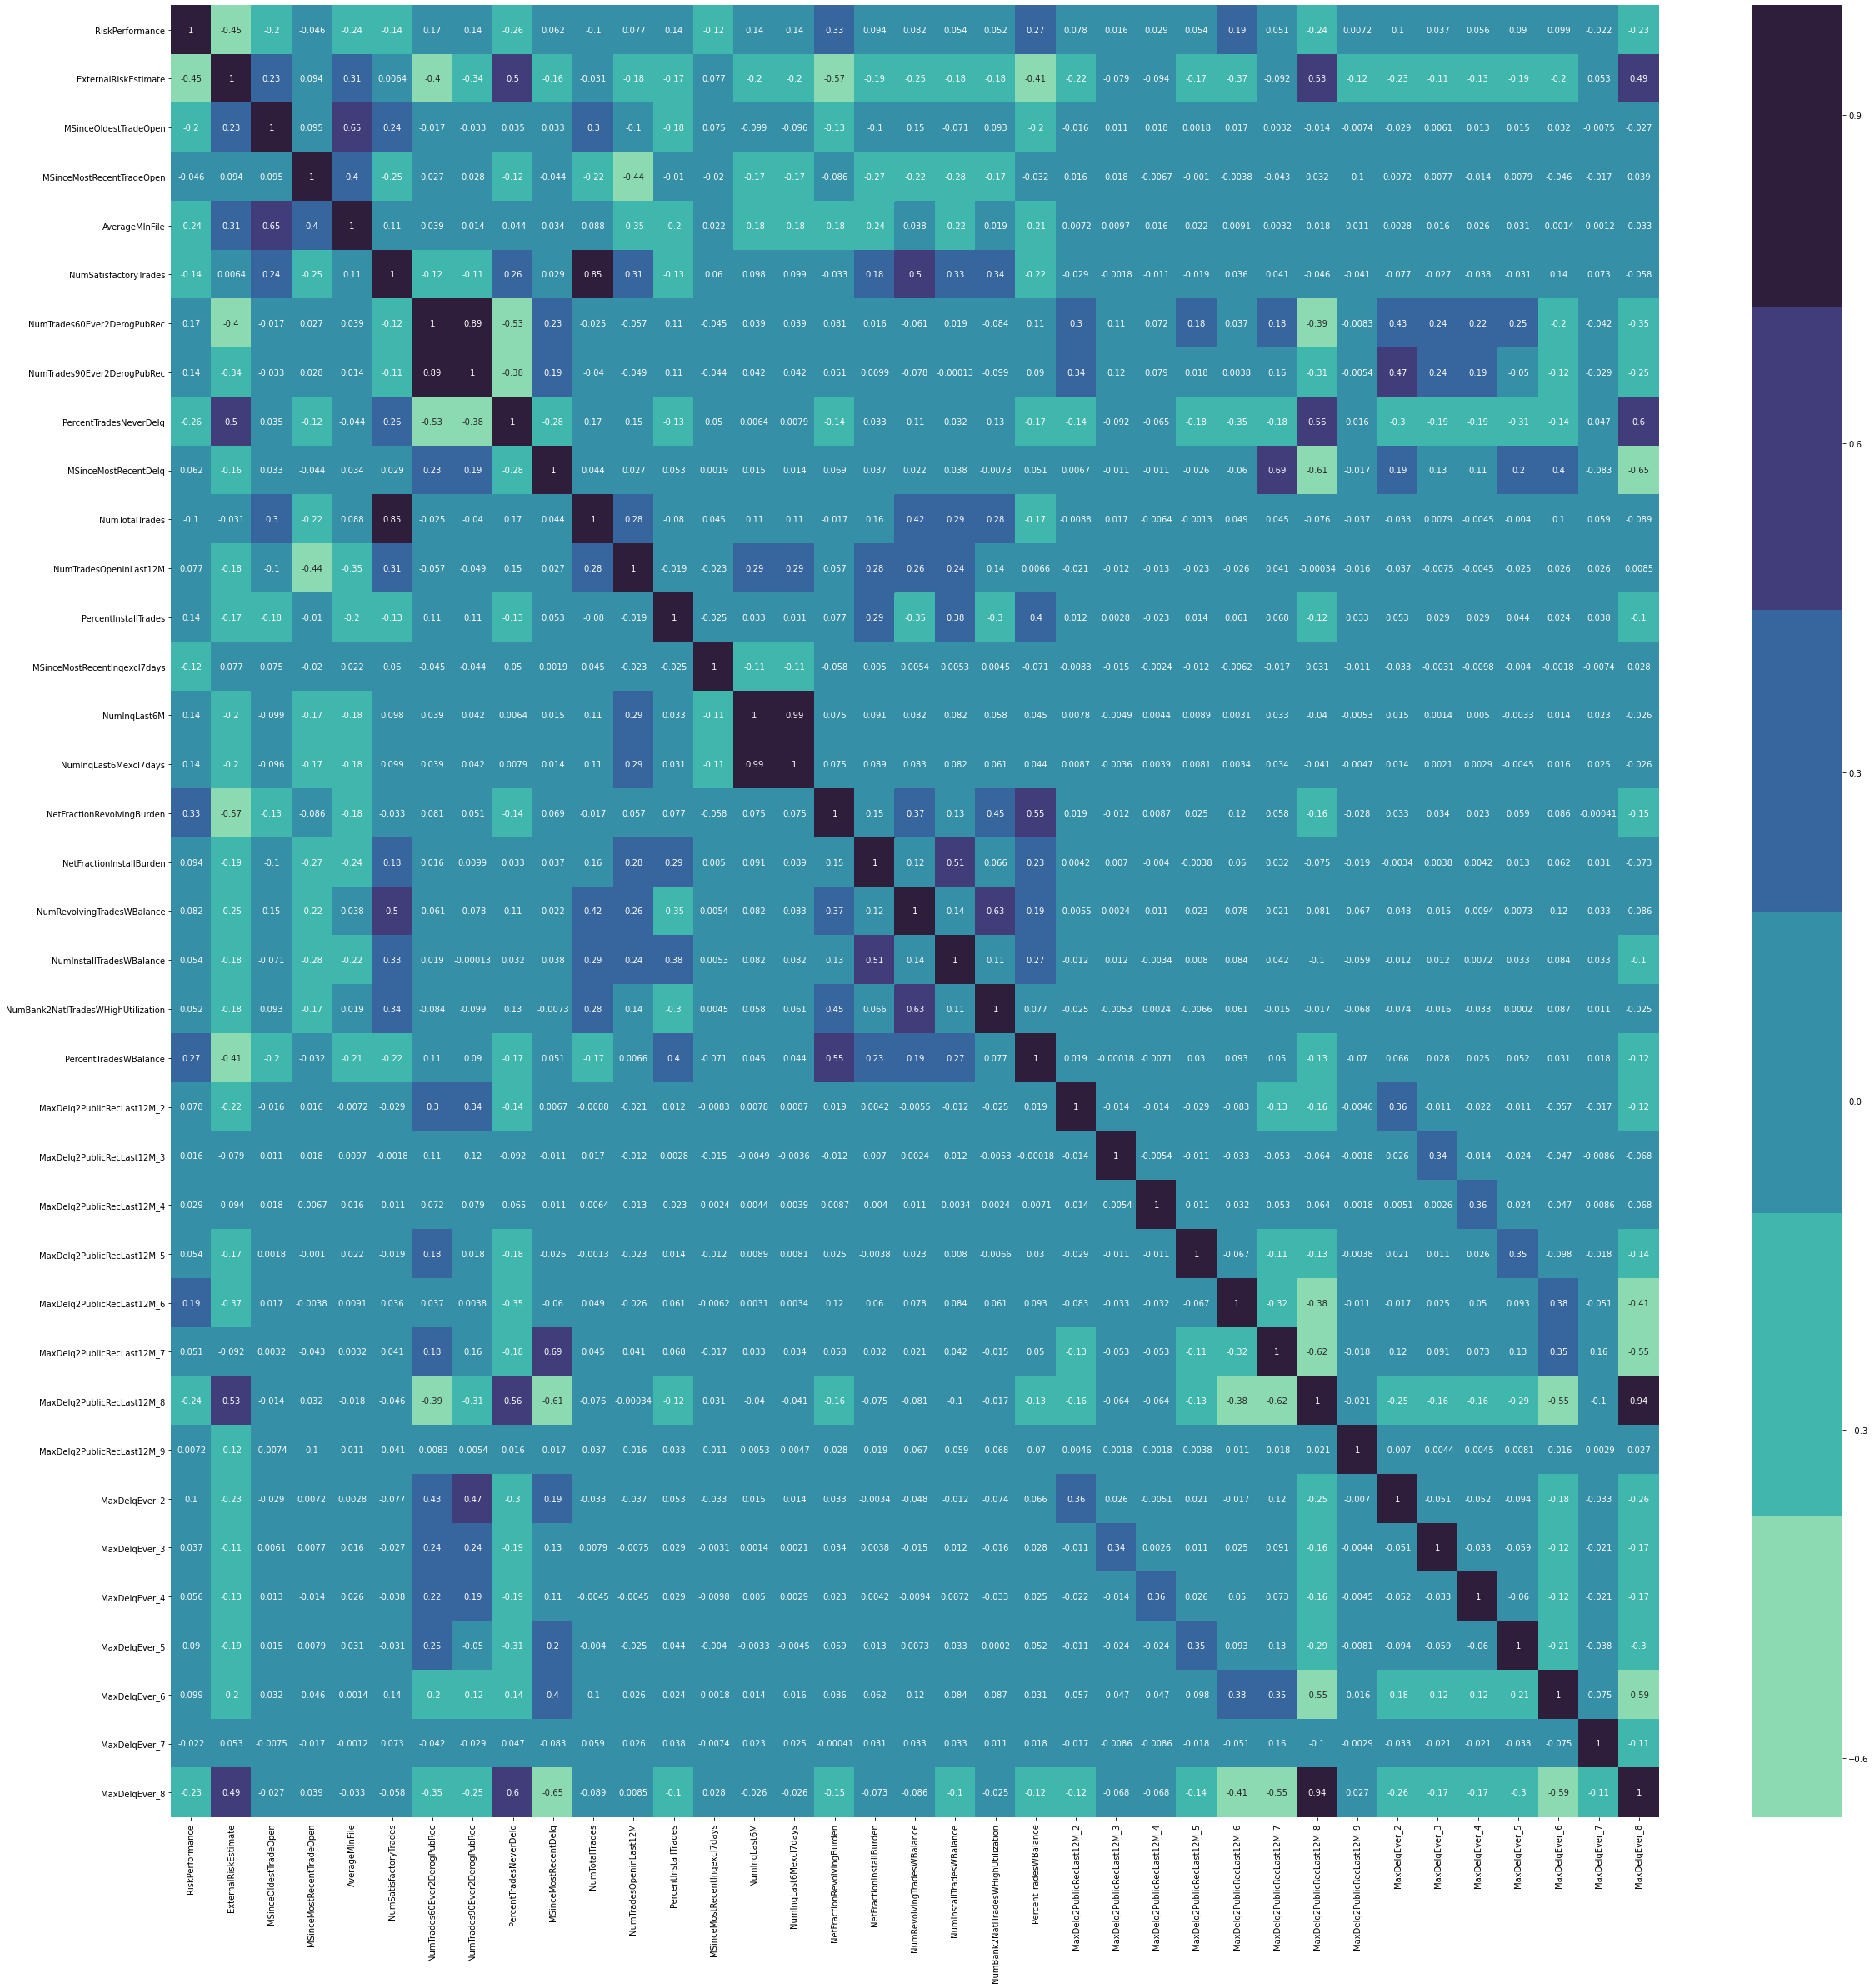

In [37]:
# Mapa de calor
plt.figure(figsize=(40,40))
sns.heatmap(cor, annot=True, cmap=color)
plt.show()



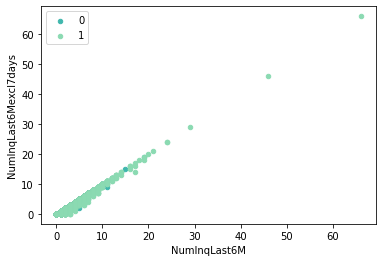

In [38]:
# Relación entre: 
# NumInqLast6M - número de consultas en los últimos 6 meses
# NumInqLast6Mexcl7days - número de consultas en los últimos 6 meses (excluidos los últimos 7 días)
# las consulas en los últimos 6 meses incluyen a las consultas en los últimos 6 meses menos lod último 7 días.

colors = {1:color[0], 0:color[1]}
fig, ax = plt.subplots()
grouped = X_enc.groupby('RiskPerformance')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter'
               ,x='NumInqLast6M', y='NumInqLast6Mexcl7days', label=key
               ,color=colors[key])
plt.show()

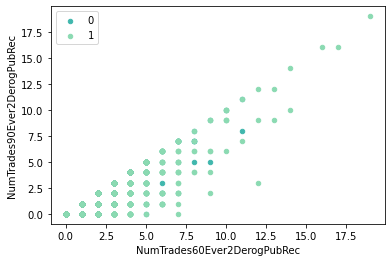

In [39]:
# Relación entre:
# NumTrades60Ever2DerogPubRec - número de operaciones que están atrasadas en más de 60
# NumTrades90Ever2DerogPubRec - número de operaciones que están atrasadas en más de 90
# los que están atrasados en más de 90 contienen a los de más de 60 días.

colors = {1:color[0], 0:color[1]}
fig, ax = plt.subplots()
grouped = X_enc.groupby('RiskPerformance')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter'
               ,x='NumTrades60Ever2DerogPubRec', y='NumTrades90Ever2DerogPubRec', label=key
               ,color=colors[key])
plt.show()

In [40]:
cor_target = cor["RiskPerformance"]
pd.DataFrame(cor_target[abs(cor_target)>0]).sort_values(by= 'RiskPerformance', ascending=False)

RiskPerformance
RiskPerformance                            1.000000
NetFractionRevolvingBurden                 0.329895
PercentTradesWBalance                      0.273118
MaxDelq2PublicRecLast12M_6                 0.186111
NumTrades60Ever2DerogPubRec                0.169747
NumInqLast6M                               0.143640
NumTrades90Ever2DerogPubRec                0.140443
PercentInstallTrades                       0.140418
NumInqLast6Mexcl7days                      0.137998
MaxDelqEver_2                              0.102086
MaxDelqEver_6                              0.099040
NetFractionInstallBurden                   0.093656
MaxDelqEver_5                              0.089552
NumRevolvingTradesWBalance                 0.082348
MaxDelq2PublicRecLast12M_2                 0.078477
NumTradesOpeninLast12M                     0.077462
MSinceMostRecentDelq                       0.062426
MaxDelqEver_4                              0.055995
NumInstallTradesWBalance                   0.054473
MaxDelq2PublicRecLast12M_5                 0.053718
NumBank2NatlTradesWHighUtilization         0.051592
MaxDelq2PublicRecLast12M_7                 0.050997
MaxDelqEver_3                              0.037360
MaxDelq2PublicRecLast12M_4                 0.028924
MaxDelq2PublicRecLast12M_3                 0.016229
MaxDelq2PublicRecLast12M_9                 0.007225
MaxDelqEver_7                             -0.022387
MSinceMostRecentTradeOpen                 -0.046343
NumTotalTrades                            -0.100787
MSinceMostRecentInqexcl7days              -0.115959
NumSatisfactoryTrades                     -0.141092
MSinceOldestTradeOpen                     -0.204511
MaxDelqEver_8                             -0.225458
MaxDelq2PublicRecLast12M_8                -0.239879
AverageMInFile                            -0.243869
PercentTradesNeverDelq                    -0.257358
ExternalRiskEstimate                      -0.449711

Las características con mayor correlación con el target, RiskPerformance,  son ExternalRiskEstimate, con una correlacion negatia de -0.449711 y NetFractionRevolvingBurden con una correlación positiva de 0.329895

In [41]:
# Separación entre predictoras y target
X = X_enc.drop("RiskPerformance",1)
y = X_enc.RiskPerformance

In [42]:
X.shape

(9871, 36)

In [43]:
y.shape

(9871,)

In [44]:
# Se calcula el escore de las características con mutual_info_classif y se selecciona las más representativas
high_score_features = []
feature_scores = mutual_info_classif(X, y, random_state=0)
df_fs = pd.DataFrame({'Feature': X.columns, 'FeatureScore': feature_scores,})
df_fs.sort_values('FeatureScore',ascending=False)


Feature  FeatureScore
0                 ExternalRiskEstimate      0.122814
15          NetFractionRevolvingBurden      0.064204
19  NumBank2NatlTradesWHighUtilization      0.055091
7               PercentTradesNeverDelq      0.043079
20               PercentTradesWBalance      0.042414
35                       MaxDelqEver_8      0.038591
3                       AverageMInFile      0.038413
12        MSinceMostRecentInqexcl7days      0.038364
27          MaxDelq2PublicRecLast12M_8      0.033799
1                MSinceOldestTradeOpen      0.032030
8                 MSinceMostRecentDelq      0.026735
5          NumTrades60Ever2DerogPubRec      0.024410
6          NumTrades90Ever2DerogPubRec      0.022818
17          NumRevolvingTradesWBalance      0.015860
25          MaxDelq2PublicRecLast12M_6      0.014523
13                        NumInqLast6M      0.013124
29                       MaxDelqEver_2      0.010941
11                PercentInstallTrades      0.010938
14               NumInqLast6Mexcl7days      0.010054
32                       MaxDelqEver_5      0.009413
4                NumSatisfactoryTrades      0.008879
10              NumTradesOpeninLast12M      0.006950
28          MaxDelq2PublicRecLast12M_9      0.006875
16            NetFractionInstallBurden      0.005473
26          MaxDelq2PublicRecLast12M_7      0.002908
2            MSinceMostRecentTradeOpen      0.002658
9                       NumTotalTrades      0.001711
18            NumInstallTradesWBalance      0.000395
24          MaxDelq2PublicRecLast12M_5      0.000000
23          MaxDelq2PublicRecLast12M_4      0.000000
30                       MaxDelqEver_3      0.000000
31                       MaxDelqEver_4      0.000000
22          MaxDelq2PublicRecLast12M_3      0.000000
33                       MaxDelqEver_6      0.000000
34                       MaxDelqEver_7      0.000000
21          MaxDelq2PublicRecLast12M_2      0.000000

In [45]:
# Se seleccionan las características por encima del umbral
threshold = 0.005
high_score = pd.Series.tolist(df_fs[df_fs.FeatureScore >threshold]['Feature'])
X = X[high_score]
X.shape

(9871, 24)

In [46]:
# se muestran las características seleccionadas
pd.DataFrame(X.columns, columns= 'Caracteristicas'.split())

Caracteristicas
0                 ExternalRiskEstimate
1                MSinceOldestTradeOpen
2                       AverageMInFile
3                NumSatisfactoryTrades
4          NumTrades60Ever2DerogPubRec
5          NumTrades90Ever2DerogPubRec
6               PercentTradesNeverDelq
7                 MSinceMostRecentDelq
8               NumTradesOpeninLast12M
9                 PercentInstallTrades
10        MSinceMostRecentInqexcl7days
11                        NumInqLast6M
12               NumInqLast6Mexcl7days
13          NetFractionRevolvingBurden
14            NetFractionInstallBurden
15          NumRevolvingTradesWBalance
16  NumBank2NatlTradesWHighUtilization
17               PercentTradesWBalance
18          MaxDelq2PublicRecLast12M_6
19          MaxDelq2PublicRecLast12M_8
20          MaxDelq2PublicRecLast12M_9
21                       MaxDelqEver_2
22                       MaxDelqEver_5
23                       MaxDelqEver_8

### 1.6. Separación el conjunto de datos en train y test

In [47]:
# se separa el dataset en conjunto de entranamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

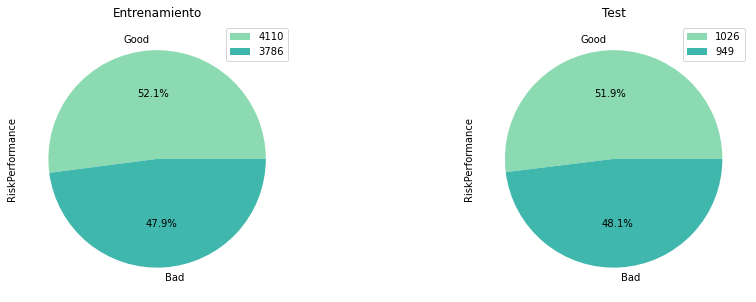

In [48]:
# Se representa graficamente los dos conjuntos creados.
figure =plt.gcf()
figure.set_size_inches(15,5)
names = ["Good","Bad"]

plt.subplot(121)
varValue = y_train.value_counts()
plot = y_train.value_counts().plot(kind='pie',colors=color
                                   ,autopct='%1.1f%%', title='Entrenamiento', labels=names)
plt.legend(list(varValue))

plt.subplot(122)
varValue = y_test.value_counts()
plot = y_test.value_counts().plot(kind='pie',colors=color
                                  ,autopct='%1.1f%%', title='Test', labels=names)
plt.legend(list(varValue))

plt.show()



## 2. Modelos 

### 2.1 Logistic Regression

#### Búsqueda mejor modelo Logistic Regresion

In [52]:
# Buscamos los mejores parámetros para el modelo de Regresión Logística
grid_values = {'penalty': ['l1','l2'], 
               'C': [0.001,0.01,0.1,1], #,3,5,8,10,15,20,30,40,50,100,1000],
               'solver' : [ 'liblinear', 'saga']}#,'lbfgs']}
clf_lr_grid = GridSearchCV(LogisticRegression(random_state=101,multi_class='ovr',class_weight='balanced'), param_grid=grid_values, cv=10, n_jobs=-1)
clf_lr_grid.fit(X_train, y_train)

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. 

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=101, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [53]:
print(clf_lr_grid.best_params_) 
y_pred_lr_grid = clf_lr_grid.predict(X_test) 
print(f1_score(y_test, y_pred_lr_grid, average='micro'))

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0.7245569620253166


#### Mejor modelo Logistic Regresion

In [49]:
# aplicamos los valores obtenidos
clf_logReg = LogisticRegression(random_state=101,multi_class='ovr',solver='liblinear',class_weight='balanced',C=1, penalty='l2')

In [50]:
# entrenamos el modelo.
clf_logReg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=101, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
# almacenamos el modelo o lo recuperamos si ya está almacenado
#joblib.dump(clf_logReg, 'modelo_logReg.pkl') # guardamos el modelo entrenado
clf_logReg = joblib.load('modelo_logReg.pkl') 

In [55]:
# predecimos en los datos de test para Regresión logística
y_pred_logReg = clf_logReg.predict(X_test)
probs_logReg  = clf_logReg.predict_proba(X_test)
preds_logReg  = probs_logReg[:,1]

fpr_logReg, tpr_logReg, threshold_logReg = roc_curve(y_test, preds_logReg)
roc_auc_logReg = auc(fpr_logReg, tpr_logReg)


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


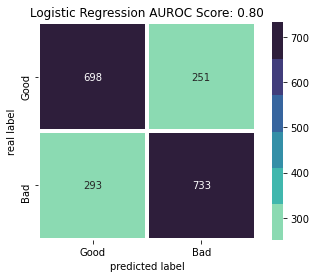

In [56]:
# mostramos la matriz de confusión para Regresión Logística
cm= confusion_matrix
cm_logReg=cm(y_test,y_pred_logReg)
sns.heatmap(cm_logReg, annot=True,fmt=".0f",linewidths=3,square=True, cmap=color, xticklabels=names, yticklabels=names)
plt.ylabel('real label')
plt.xlabel('predicted label')
plt.title('Logistic Regression AUROC Score: {0:.2f}'.format(roc_auc_logReg),size=12)
plt.show()

### 2.2 Decision Tree

#### Búsqueda mejor modelo Decision Tree

In [ ]:
# Buscamos los mejores parámetros para el modelo de Árbol de decisión
grid_values = {'criterion':['gini'],
               'max_depth':[4,5], 
               'max_leaf_nodes': list(range(20, 120)), 
               'min_samples_split': [2, 3, 4]}
clf_dt_grid = GridSearchCV(DecisionTreeClassifier(), param_grid=grid_values, cv=10, n_jobs=-1)
clf_dt_grid.fit(X_train, y_train)

In [57]:
print(clf_dt_grid.best_params_) 
y_pred_dt_grid = clf_dt_grid.predict(X_test) 
print(f1_score(y_test, y_pred_dt_grid, average='micro'))


{'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 21, 'min_samples_split': 2}
0.7099932478055369


#### Mejor modelo Decision Tree

In [56]:
clf_decTree = DecisionTreeClassifier(criterion='gini',
                                     max_depth = 5,
                                     max_leaf_nodes=21,
                                     min_samples_split=2,
                                     min_samples_leaf=20,
                                     min_impurity_decrease=0.0,
                                     min_weight_fraction_leaf=0.0)

In [ ]:
clf_decTree.fit(X_train, y_train)

In [57]:
# almacenamos el modelo o lo recuperamos si ya está almacenado
#joblib.dump(clf_decTree, 'modelo_decTree.pkl') # guardamos el modelo entrenado
clf_decTree = joblib.load('modelo_decTree.pkl') 

In [58]:
y_pred_decTree = clf_decTree.predict(X_test)
probs_decTree  = clf_decTree.predict_proba(X_test)
preds_decTree  = probs_decTree[:,1]

fpr_decTree, tpr_decTree, threshold_decTree = roc_curve(y_test, preds_decTree)
roc_auc_decTree = auc(fpr_decTree, tpr_decTree)


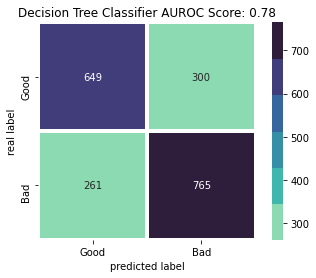

In [59]:
# mostramos la matriz de confusión para Árbol de Decisión
cm= confusion_matrix
cm_decTree=cm(y_test,y_pred_decTree)
sns.heatmap(cm_decTree, annot=True,fmt=".0f",linewidths=3,square=True, cmap=color
            , xticklabels=names, yticklabels=names)
plt.ylabel('real label')
plt.xlabel('predicted label')
plt.title('Decision Tree Classifier AUROC Score: {0:.2f}'.format(roc_auc_decTree),size=12)
plt.show()

### 2.3 Neural Network

In [60]:
# preparación de etiquetas.
n_classes = 2
input_shape = X.shape[1]
y_train_NN = keras.utils.to_categorical(y_train, n_classes)
y_test_NN = keras.utils.to_categorical(y_test, n_classes)

#### Búsqueda mejor modelo Neural Network

In [227]:
# Definimos el método para generar el modelo en función de los parámetros que queramos variar en la búsqueda de GridSearchCV
def create_model(activation = 'relu',
              dropout_rate = 0.2,
              optimizer = 'Adam'):
    # configuramos el modelo secuencial y capas densas
    model = Sequential()
    model.add(Dense(256, activation=activation, input_shape=(input_shape,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))

    model.add(Dense(2, activation='softmax'))
    # compilamos el modelo
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [228]:
model = KerasClassifier(build_fn=create_model,
                        verbose=0)

In [ ]:
# buscamos la mejor aproximación del modelo Red Neuronal
grid_values = {'epochs' :             [10,15,20],
              'batch_size' :          [64, 128],
              'optimizer' :           ['Adam', 'Nadam','RMSprop'],
              #'dropout_rate' :        [0.2, 0.3],
              #'activation' :          ['relu', 'elu']
             }
clf_cnn_grid = GridSearchCV(estimator=model, param_grid=grid_values, cv=10, n_jobs=-1)
clf_cnn_grid.fit(X_train, y_train_NN)

In [ ]:
print(clf_cnn_grid.best_params_) 
y_pred_cnn_grid = clf_cnn_grid.predict(X_test) 
print(f1_score(y_test, y_pred_cnn_grid, average='micro'))

#### Mejor modelo Neural Network

In [59]:
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(input_shape,)))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               6400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

In [60]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [ ]:
# Entrenamos el modelo de Red Neuronal
batch_size= 128
n_epochs =100
history = model.fit(X_train, y_train_NN,
                    batch_size=batch_size,
                    epochs=n_epochs,
                    validation_data=(X_test, y_test_NN),
                    verbose=1)

In [61]:
# Se almacena el modelo o se recupera si ya está almacenado
#model.save('modelo_CNN.h5')
model = keras.models.load_model('modelo_CNN.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [62]:
# Se calculan las predicciones para el modelo entrenado y se calculan las métricas
y_pred_NN = model.predict(X_test) 
probs_NN  = model.predict_proba(X_test)
preds_NN  = probs_NN[:,1]
probs_NN = np.argmax(probs_NN, axis= 1)

fpr_NN, tpr_NN, threshold_NN = roc_curve(y_test, preds_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)


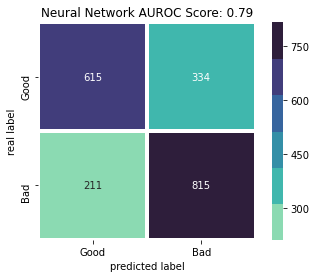

In [63]:
# Se muestra la matriz de confusión para Red Neuronal
cm= confusion_matrix
cm_NN=cm(y_test,np.argmax(y_pred_NN, axis=1))
sns.heatmap(cm_NN, annot=True,fmt=".0f",linewidths=3,square=True, cmap=color
            , xticklabels=names, yticklabels=names)
plt.ylabel('real label')
plt.xlabel('predicted label')
plt.title('Neural Network AUROC Score: {0:.2f}'.format(roc_auc_NN),size=12)
plt.show()

### 2.4 XGBClassifier

#### Búsqueda mejor modelo XGBoost

In [ ]:
# Se calcula los mejores parámetros para XGBClassifier
grid_values = {'min_child_weight': [1, 5, 10],
               'gamma': [0.5, 1, 1.5, 2, 5],
               "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
               'subsample': [0.6, 0.8, 1.0],
               'colsample_bytree': [0.6, 0.8, 1.0],
               'max_depth': [3, 4, 5],
               'n_estimators':[150,300]
              }
clf_XGB_grid = GridSearchCV(XGBClassifier(), param_grid=grid_values, cv=10, n_jobs=-1)
clf_XGB_grid.fit(X_train, y_train)

In [149]:
# Se muestran los mejores parámetros conseguidos
print(clf_XGB_grid.best_params_) 
y_pred_XGB_grid = clf_XGB_grid.predict(X_test) 
print(f1_score(y_test, y_pred_XGB_grid, average='micro'))

{'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 150, 'subsample': 1.0}
0.7336259284267387


#### Mejor modelo XGBoost 

In [78]:
# Se aplica los parámetros obtenidos
clf_xgb = XGBClassifier( colsample_bytree = 1,
                        gamma = 0,
                        learning_rate = 0.1,
                        max_depth=3,
                        min_child_weight =1,
                        n_estimators=150,
                        subsample = 1
                       )
clf_xgb.fit(X_train, y_train)

[13:43:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [58]:
# Se aplican los parámetros obtenidos
clf_xgb = XGBClassifier( colsample_bytree = 0.8,
                        gamma = 5,
                        learning_rate = 0.05,
                        max_depth=5,
                        min_child_weight =10,
                        n_estimators=150,
                        subsample = 1
                       )
clf_xgb.fit(X_train, y_train)



[20:06:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [64]:
# Se almacena el modelo o se recupera si ya está almacenado
#joblib.dump(clf_xgb, 'modelo_xgb.pkl') 
clf_xgb = joblib.load('modelo_xgb.pkl') 

In [65]:
# Se calculan las predicciones para el modelo entrenado y se calculan las métricas
y_pred_xgb = clf_xgb.predict(X_test)
probs_xgb  = clf_xgb.predict_proba(X_test)
preds_xgb  = probs_xgb[:,1]

fpr_xgb, tpr_xgb, threshold_xgb = roc_curve(y_test, preds_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)


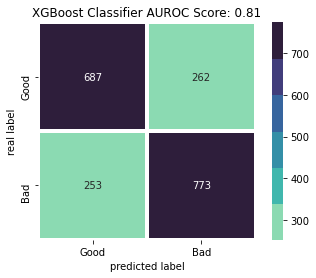

In [66]:
# Se muestra la matriz de confusión para XGBoost
cm= confusion_matrix
cm_XGB=cm(y_test,y_pred_xgb)
sns.heatmap(cm_XGB, annot=True,fmt=".0f",linewidths=3,square=True, cmap=color
            , xticklabels=names, yticklabels=names)
plt.ylabel('real label')
plt.xlabel('predicted label')
plt.title('XGBoost Classifier AUROC Score: {0:.2f}'.format(roc_auc_xgb),size=12)
plt.show()

### 2.5. Comparativa  de precisión de modelos

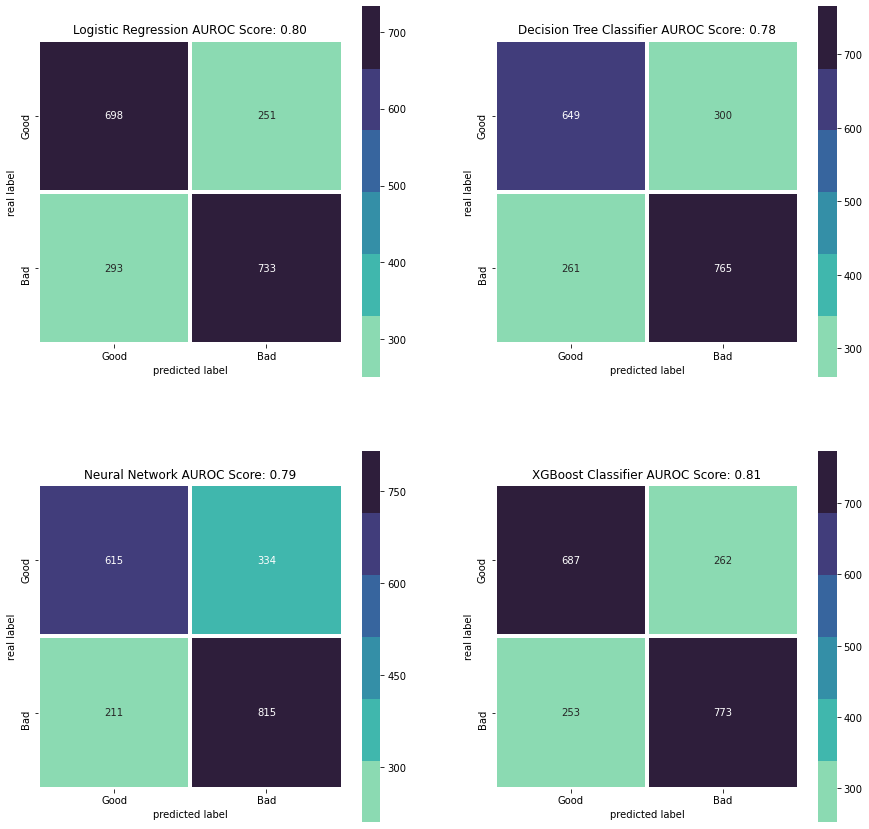

In [67]:
# Se muestran las cuatro matrices de confusión correspondientes a cada modelo.
figure =plt.gcf()
figure.set_size_inches(15,15)


plt.subplot(221)
# mostramos la matriz de confusión para Regresión Logística
sns.heatmap(cm_logReg, annot=True,fmt=".0f",linewidths=3,square=True, cmap=color, xticklabels=names, yticklabels=names)
plt.ylabel('real label')
plt.xlabel('predicted label')
plt.title('Logistic Regression AUROC Score: {0:.2f}'.format(roc_auc_logReg),size=12)

plt.subplot(222)
# mostramos la matriz de confusión para Árbol de Decisión
sns.heatmap(cm_decTree, annot=True,fmt=".0f",linewidths=3,square=True, cmap=color
            , xticklabels=names, yticklabels=names)
plt.ylabel('real label')
plt.xlabel('predicted label')
plt.title('Decision Tree Classifier AUROC Score: {0:.2f}'.format(roc_auc_decTree),size=12)

plt.subplot(223)
# Se muestra la matriz de confusión para Red Neuronal
sns.heatmap(cm_NN, annot=True,fmt=".0f",linewidths=3,square=True, cmap=color
            , xticklabels=names, yticklabels=names)
plt.ylabel('real label')
plt.xlabel('predicted label')
plt.title('Neural Network AUROC Score: {0:.2f}'.format(roc_auc_NN),size=12)

plt.subplot(224)
# Se muestra la matriz de confusión para XGBoost
sns.heatmap(cm_XGB, annot=True,fmt=".0f",linewidths=3,square=True, cmap=color
            , xticklabels=names, yticklabels=names)
plt.ylabel('real label')
plt.xlabel('predicted label')
plt.title('XGBoost Classifier AUROC Score: {0:.2f}'.format(roc_auc_xgb),size=12)


plt.show()

In [68]:
df_score = pd.DataFrame({'AUROC Score':[np.round(roc_auc_logReg,2), 
                                      np.round(roc_auc_decTree,2), 
                                      np.round(roc_auc_NN,2), 
                                      np.round(roc_auc_xgb,2)]}, 
                        index=['Regresión Logística','Árbol de Decisión','Red Neuronal','XGBoost'])
df_score

AUROC Score
Regresión Logística         0.80
Árbol de Decisión           0.78
Red Neuronal                0.79
XGBoost                     0.81

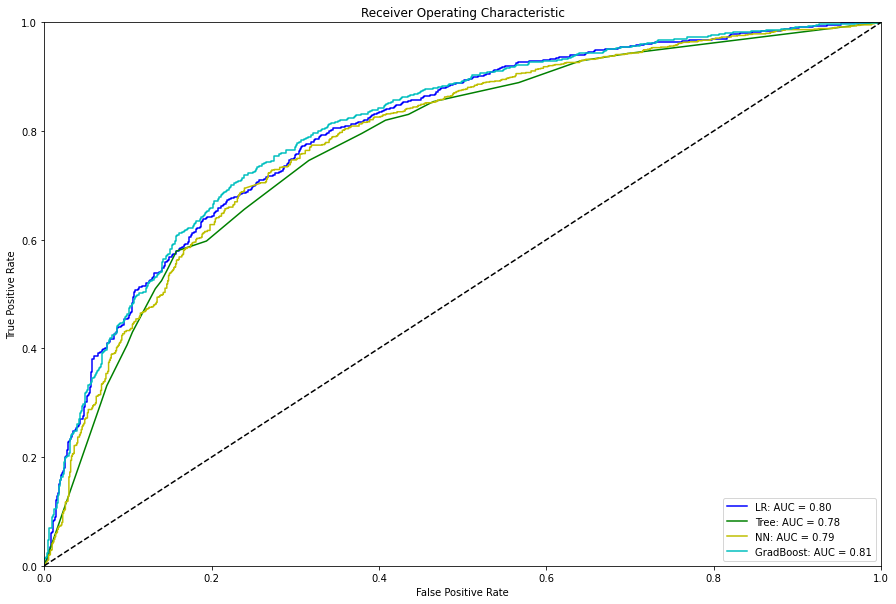

In [69]:
# se muestra la gráfica de la curva ROC para cada uno de los modelos entrenados.
plt.figure(figsize=(15,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_logReg, tpr_logReg, 'b', label='LR: AUC = {0:.2f}'.format(roc_auc_logReg))
plt.plot(fpr_decTree, tpr_decTree, 'g', label='Tree: AUC = {0:.2f}'.format(roc_auc_decTree))
plt.plot(fpr_NN, tpr_NN, 'y', label='NN: AUC = {0:.2f}'.format(roc_auc_NN))
plt.plot(fpr_xgb, tpr_xgb, 'c', label='GradBoost: AUC = {0:.2f}'.format(roc_auc_xgb))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 3. Explicabilidad

In [70]:
# Se selecciona un ejemplo para mostrar la explicación en cada modelo
sample_id = 428

### 3.1. Logistic Regresion

In [71]:
# A partir de la información de los coeficiente de regresión se obtienen los correspondientes valores de odds, aplicanco exp
odds = np.exp(clf_logReg.coef_[0])
df_coef_odds_LR=pd.concat([pd.Series(X_train.columns),pd.Series(clf_logReg.coef_[0]),pd.Series(odds)], axis = 1)
df_coef_odds_LR.columns =['features','coef','odds']
df_coef_odds_LR.set_index('features').sort_values(by='coef',ascending=False)

coef      odds
features                                              
NumInqLast6M                        0.407176  1.502568
MaxDelq2PublicRecLast12M_6          0.276195  1.318105
NumTrades90Ever2DerogPubRec         0.089424  1.093544
MaxDelqEver_5                       0.067424  1.069749
NumRevolvingTradesWBalance          0.066618  1.068887
MaxDelqEver_2                       0.057419  1.059100
NetFractionRevolvingBurden          0.012933  1.013017
PercentInstallTrades                0.007861  1.007891
NumTradesOpeninLast12M              0.007685  1.007715
NetFractionInstallBurden           -0.000145  0.999856
MSinceOldestTradeOpen              -0.000855  0.999145
PercentTradesWBalance              -0.001572  0.998429
MSinceMostRecentDelq               -0.005953  0.994065
PercentTradesNeverDelq             -0.007430  0.992598
AverageMInFile                     -0.008066  0.991966
NumTrades60Ever2DerogPubRec        -0.016817  0.983324
MSinceMostRecentInqexcl7days       -0.025856  0.974475
NumSatisfactoryTrades              -0.031428  0.969061
NumBank2NatlTradesWHighUtilization -0.039371  0.961394
ExternalRiskEstimate               -0.048740  0.952429
MaxDelq2PublicRecLast12M_9         -0.190457  0.826581
MaxDelq2PublicRecLast12M_8         -0.212509  0.808553
MaxDelqEver_8                      -0.242648  0.784547
NumInqLast6Mexcl7days              -0.309937  0.733493

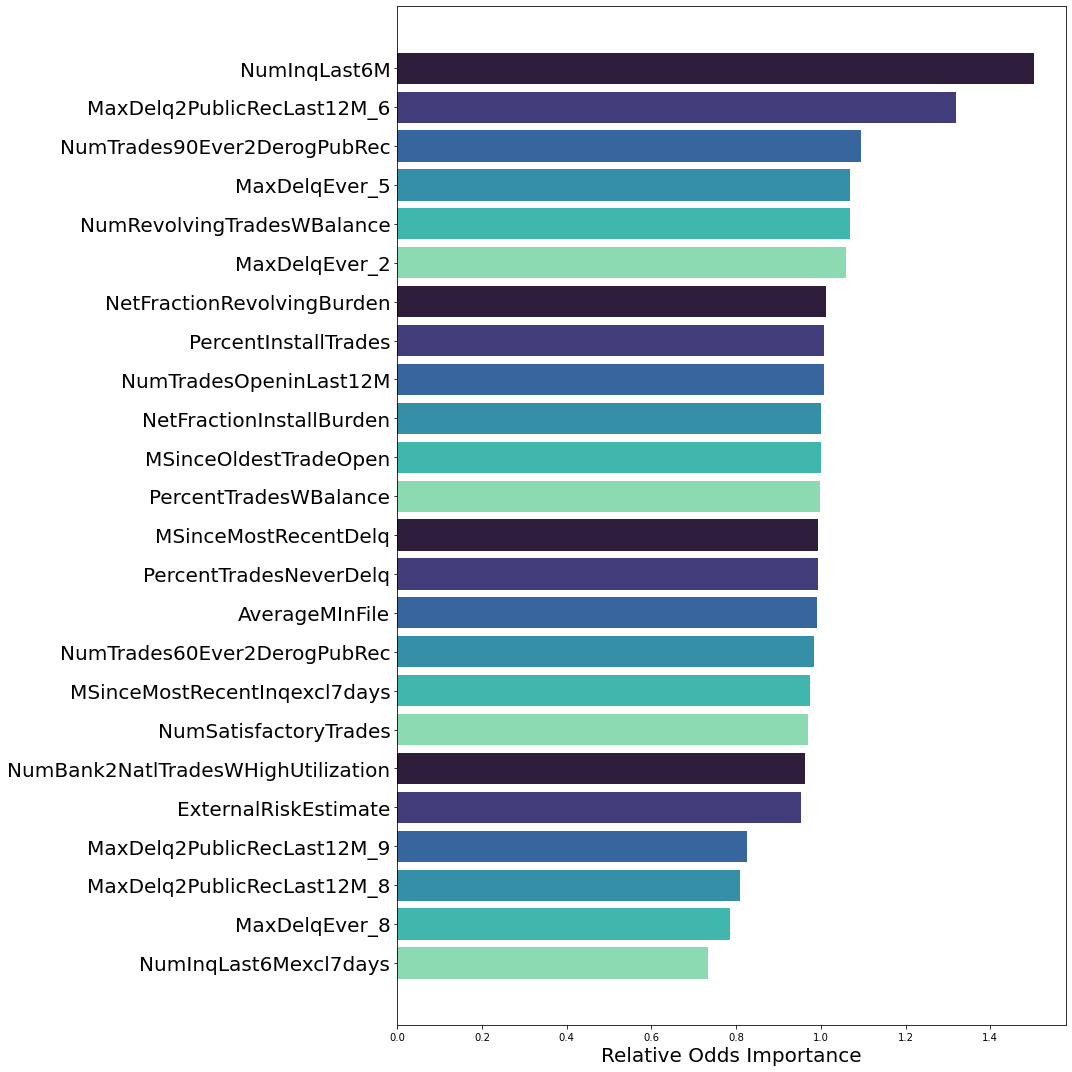

In [72]:
# Se muestran las características por orden de importancia y su signo 
odds_importance_logReg = odds
sorted_idx_logReg = np.argsort(odds_importance_logReg)
pos = np.arange(sorted_idx_logReg.shape[0]) 

featfig = plt.figure(figsize=(15,15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, odds_importance_logReg[sorted_idx_logReg], align='center',color=color)
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train.columns)[sorted_idx_logReg], fontsize=20)
featax.set_xlabel('Relative Odds Importance', fontsize=20)

plt.tight_layout()
plt.show()


### Para una instancia

In [73]:
# Se almacena la información relativa a la regresión logística:
# características (se incluye también el coeficiente betha0 como biasCoefficient)
# valor de la característica para la instancia
# coeficiente de regresión
# odd asociado al coeficiente
# multiplicación del valor por el coeficiente
df_exp_inst_LR=pd.concat([pd.Series(np.append(['biasCoefficient'],X_test.columns)),
                          pd.Series(np.append([1],X_test.iloc[sample_id])),
                          pd.Series(np.append([clf_logReg.intercept_],clf_logReg.coef_[0])),
                          pd.Series(np.append([0],np.exp(clf_logReg.coef_[0]))),
                          pd.Series(np.append([clf_logReg.intercept_],X_test.iloc[sample_id] * clf_logReg.coef_[0]))
                         ], axis = 1)
df_exp_inst_LR.columns =['features','Xi','coefi','oddsi','Xi_x_coefi']
df_exp_inst_LR.set_index('features')
df_exp_inst_LR[df_exp_inst_LR['Xi']>0].sort_values(by='coefi',ascending=False)

features     Xi     coefi     oddsi  Xi_x_coefi
0              biasCoefficient    1.0  4.834994  0.000000    4.834994
12                NumInqLast6M    9.0  0.407176  1.502568    3.664582
19  MaxDelq2PublicRecLast12M_6    1.0  0.276195  1.318105    0.276195
16  NumRevolvingTradesWBalance    2.0  0.066618  1.068887    0.133236
14  NetFractionRevolvingBurden   14.0  0.012933  1.013017    0.181062
10        PercentInstallTrades   43.0  0.007861  1.007891    0.338002
9       NumTradesOpeninLast12M    9.0  0.007685  1.007715    0.069166
15    NetFractionInstallBurden   67.0 -0.000145  0.999856   -0.009682
2        MSinceOldestTradeOpen  148.0 -0.000855  0.999145   -0.126564
18       PercentTradesWBalance   67.0 -0.001572  0.998429   -0.105344
8         MSinceMostRecentDelq    6.0 -0.005953  0.994065   -0.035717
7       PercentTradesNeverDelq   93.0 -0.007430  0.992598   -0.690959
3               AverageMInFile   47.0 -0.008066  0.991966   -0.379103
4        NumSatisfactoryTrades   24.0 -0.031428  0.969061   -0.754266
1         ExternalRiskEstimate   73.0 -0.048740  0.952429   -3.558036
13       NumInqLast6Mexcl7days    9.0 -0.309937  0.733493   -2.789436

In [119]:
# Se aplica la fórmula (1) de la regresión logística para obtener la P(y=1) 
# se muestra dicha probabilidad y la etiqueta real para la instancia
p= 1/(1+np.exp(-(df_exp_inst_LR.Xi_x_coefi.sum())))
print('P(y_Test[{0}]=1)={1}. Etiqueta = {2}'.format(sample_id, p, y_test.iloc[sample_id]))

P(y_Test[428]=1)=0.7736648420510022. Etiqueta = 1


### 3.2. Decision Tree

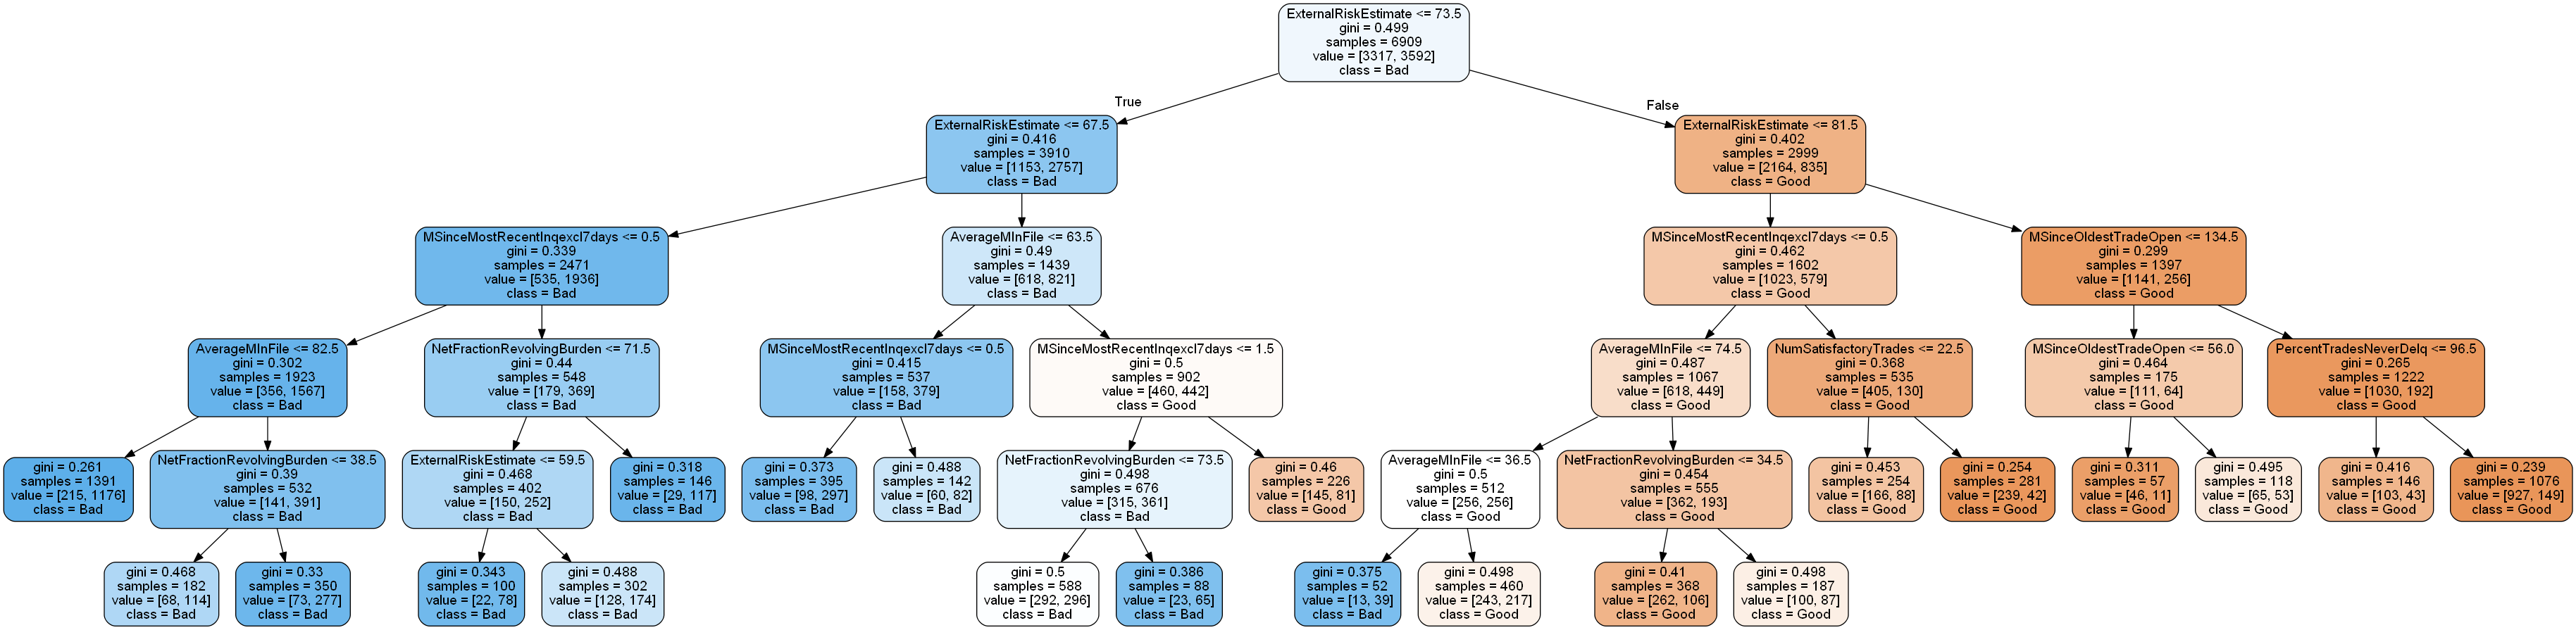

In [74]:
# se exporta el modelo a archivo .dot
feature_names = X_train.columns
with open(r"tree.dot", 'w') as f:
     f = tree.export_graphviz(clf_decTree,
                              out_file=f,
                              max_depth = 10,
                              impurity = True,
                              feature_names = feature_names,
                              class_names = ['Good', 'Bad'],
                              rounded = True,
                              filled= True )

# se convierte el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree.dot','-o',r'tree.png'])
PImage("tree.png")


In [75]:
# se pinta el árbol en forma de texto
tree_text = export_text(clf_decTree, feature_names=list(feature_names))
print(tree_text)

|--- ExternalRiskEstimate <= 73.50
|   |--- ExternalRiskEstimate <= 67.50
|   |   |--- MSinceMostRecentInqexcl7days <= 0.50
|   |   |   |--- AverageMInFile <= 82.50
|   |   |   |   |--- class: 1
|   |   |   |--- AverageMInFile >  82.50
|   |   |   |   |--- NetFractionRevolvingBurden <= 38.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- NetFractionRevolvingBurden >  38.50
|   |   |   |   |   |--- class: 1
|   |   |--- MSinceMostRecentInqexcl7days >  0.50
|   |   |   |--- NetFractionRevolvingBurden <= 71.50
|   |   |   |   |--- ExternalRiskEstimate <= 59.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- ExternalRiskEstimate >  59.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- NetFractionRevolvingBurden >  71.50
|   |   |   |   |--- class: 1
|   |--- ExternalRiskEstimate >  67.50
|   |   |--- AverageMInFile <= 63.50
|   |   |   |--- MSinceMostRecentInqexcl7days <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- MSinceMostRecentInqexcl7days >  0.50
|   |   |   

In [76]:
# Se obtienen las características que intervienen en el árbol de decisión
feature_importance_decTree = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf_decTree.feature_importances_,3)})
feature_importance_decTree = feature_importance_decTree.sort_values('importance',ascending=False)
feature_importance_decTree[feature_importance_decTree.importance>0]

feature  importance
0           ExternalRiskEstimate       0.806
2                 AverageMInFile       0.064
10  MSinceMostRecentInqexcl7days       0.060
13    NetFractionRevolvingBurden       0.031
1          MSinceOldestTradeOpen       0.020
3          NumSatisfactoryTrades       0.011
6         PercentTradesNeverDelq       0.007

In [77]:
# Para una muestra dada, se obtiene las reglas que aplican para la toma de decisión.
# se obtiene la información del camino, las hojas, las características asociada a cada nodo y el umbral de corte.
indicator_path = clf_decTree.decision_path(X_test)
leaf_id = clf_decTree.apply(X_test)
feature_tree = clf_decTree.tree_.feature
threshold = clf_decTree.tree_.threshold


# se obtienen los indicadores del camino para el ejemplo a tratar
node_index = indicator_path.indices[indicator_path.indptr[sample_id]:
                                    indicator_path.indptr[sample_id + 1]]


print('Reglas utlizadas para predecir el ejemplo {id} cuya etiqueta real es {label}:'.format(id=sample_id
                                                                                             ,label=y_test.iloc[sample_id]))

for node_id in node_index:
    # Si es una hoja
    if leaf_id[sample_id] == node_id:
        if clf_decTree.tree_.value[node_id][0][0] > clf_decTree.tree_.value[node_id][0][1]:
            print('Clase predicha 0')
        else:
            print('Clase predicha 1')
        continue

    # Comprobamos el valor del nodo con el umbral de la regla para marcar un > o <
    if (X_test[feature_names[feature_tree[node_id]]].iloc[sample_id] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision node {node} : (X_test[{sample}, {feature_tree}] = {value}) "
          "{inequality} {threshold})".format(
              node=node_id,
              sample=sample_id,
              feature_tree=feature_names[feature_tree[node_id]],
              value=X_test[feature_names[feature_tree[node_id]]].iloc[sample_id],
              inequality=threshold_sign,
              threshold=threshold[node_id]))



Reglas utlizadas para predecir el ejemplo 428 cuya etiqueta real es 1:
decision node 0 : (X_test[428, ExternalRiskEstimate] = 73.0) <= 73.5)
decision node 1 : (X_test[428, ExternalRiskEstimate] = 73.0) > 67.5)
decision node 4 : (X_test[428, AverageMInFile] = 47.0) <= 63.5)
decision node 7 : (X_test[428, MSinceMostRecentInqexcl7days] = -7.0) <= 0.5)
Clase predicha 1


### 3.3 LIME

##### CNN + LIME

In [78]:
classes=[0,1]
all_feat=X_train.columns
categorical_features = []
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(),mode='classification',
                                                   feature_selection= 'auto', class_names=classes,
                                                   feature_names = all_feat, categorical_features=categorical_features)

In [ ]:
exp_cnn = explainer.explain_instance(X_test.to_numpy()[sample_id], model.predict, num_features=5)

In [80]:
exp_cnn.show_in_notebook()

##### XGBClassifier + LIME

In [ ]:
exp_xgb = explainer.explain_instance(X_test.to_numpy()[sample_id], clf_xgb.predict_proba, num_features=5)

In [82]:
exp_xgb.show_in_notebook()

## SHAP

##### CNN  + SHAP

In [83]:
shap_explainer_cnn = shap.KernelExplainer(model.predict,X_test.iloc[:50,:])

In [ ]:
shap_values_cnn= shap_explainer_cnn.shap_values(X_test.iloc[sample_id,:], nsamples=500)

In [85]:
shap.initjs()

i_pred_NN = np.argmax(y_pred_NN[sample_id])
print('\nEtiqueta real = {0}. Predicción = {1} ({2:.2f}%)'.format(y_test.iloc[sample_id], 
                                                            i_pred_NN, 
                                                            y_pred_NN[sample_id][i_pred_NN]*100))
shap.force_plot(shap_explainer_cnn.expected_value[i_pred_NN], shap_values_cnn[i_pred_NN], X_test.iloc[sample_id,:])


Etiqueta real = 1. Predicción = 1 (82.41%)


##### XGBClassifier + SHAP

In [86]:
shap_explainer_xgb = shap.TreeExplainer(clf_xgb)
shap_values_xgb = shap_explainer_xgb.shap_values(X_test)
#np.abs(shap_values_xgb[sample_id,:].sum() + shap_explainer_xgb.expected_value - y_pred_xgb).max()

In [87]:
shap.initjs()

print('\nEtiqueta real = {0}. Predicción = {1}'.format(y_test.iloc[sample_id], y_pred_xgb[sample_id]))
shap.force_plot(shap_explainer_xgb.expected_value, shap_values_xgb[sample_id,:], X_test.iloc[sample_id,:])


Etiqueta real = 1. Predicción = 1


## Métricas Explicabilidad.

### Inicialización de los datos comunes

In [88]:
# agrupación de características para la métrica de agrupación con signo opuesto
# tanto con nombre de columnas como de posición.
group=[['MSinceOldestTradeOpen', 'AverageMInFile'], 
       ['NumTrades60Ever2DerogPubRec','NumTrades90Ever2DerogPubRec'], 
       ['PercentTradesNeverDelq', 'MSinceMostRecentDelq'],
       ['MaxDelq2PublicRecLast12M_6','MaxDelq2PublicRecLast12M_9','MaxDelqEver_2','MaxDelqEver_5'],
       ['MaxDelq2PublicRecLast12M_8','MaxDelqEver_8'],
       ['PercentInstallTrades','NetFractionInstallBurden'],
       ['MSinceMostRecentInqexcl7days','NumInqLast6M','NumInqLast6Mexcl7days'],
       ['NetFractionRevolvingBurden','NumRevolvingTradesWBalance']
      ]
group_iloc=[[1,2],[4,5],[6,7],[18,20,21,22],[19,23],[9,14],[10,11,12],[13,15]]

In [89]:
# se seleccionan los 1000 primeros ejemplares de X_test para las métricas.
X_explc = X_test[:1000] 
col= X_explc.columns
indx= X_explc.index

In [90]:
# se almacenan los datos que se van a utilizar para obtener métricas.
name_file= 'X_explc.csv'
X_explc.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

### 1. Regresión Logística

In [91]:
## en caso de ser necessario almanacenar y recuperar información para tratamiento posterior
## almacenamiento de la información de los coeficientes de la regresión logística 
#name_file= 'clf_logReg.csv'
#df_clf_logReg=pd.DataFrame(clf_logReg.coef_[0], columns = 'CoefLogReg'.split())
#df_clf_logReg.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

## lectura de datos almacenados.
#df_carga_logReg = pd.read_csv("clf_logReg.csv", header=0, index_col =0, decimal=',', sep=';')
#df_carga_logReg.shape

In [92]:
# se multiplica cada instancia por los coeficientes y se sustituye los NaN por 0, para calcuar:
# unidades básicas de explicación: número de ellos que son distintos de cero.
# unidades derivadas: si la columna ExternalRiskEstimate distinta de cero.
Z= X_explc * clf_logReg.coef_[0]
Z= Z.replace(np.nan,0)
# se multiplican solo los que tienen valores especiales por los pesos para calcular:
# valores especiales: número de ellos que son no nulos y distintos de cero.
P= X_explc[(X_explc==-9) |(X_explc==-8) |(X_explc==-7)] * clf_logReg.coef_[0] 


df_LR= pd.concat([Z[Z==0].isnull().sum(axis=1),                               # unidades básicas de explicación
                  pd.DataFrame(Z.ExternalRiskEstimate).ne(0).sum(axis=1),     # unidades derivadas 
                  (P.notnull().sum(axis=1)-P[P.eq(0)].notnull().sum(axis=1))  # valores especiales 
                  ], axis = 1)
df_LR.columns=['NumFeatures','HasExternalRiskEstimate','SpecialValues'] 
df_LR.set_index(Z.index)
df_LR.describe()

NumFeatures  HasExternalRiskEstimate  SpecialValues
count  1000.000000                   1000.0    1000.000000
mean     15.612000                      1.0       1.236000
std       1.756856                      0.0       1.025356
min       8.000000                      1.0       0.000000
25%      14.000000                      1.0       1.000000
50%      16.000000                      1.0       1.000000
75%      17.000000                      1.0       2.000000
max      20.000000                      1.0       8.000000

In [93]:
# agrupación con signo opuesto

# para cada grupo i de características
# partiendo de la multiplicación de beta * x 
metric_group=[]
column_group=[]
for i in range(np.shape(group)[0]):
    # aquellos que son distinto de 0 en más de una característica del grupo
    Z_group= Z[group[i]][(Z[group[i]].ne(0).sum(axis=1).gt(1))]
    # se calcula cuántos hay
    over2 = Z_group.count()[0]
    # si es cero, el valor de la métrica para este grupo será cero.
    if over2 ==0:
        metric_group.append(0)
        column_group.append('Group'+str(i))
    else:
        # si no es cero, se cuentan aquellos que tienen más de una columna con signo distinto dentro del grupo
        # para ello se cuenta el nº de elementos menores que cero para ese grupo 
        # si no es 0 ni el nº elementos del grupo, significa que hay alguno de distinto signo
        sign= Z_group[(Z_group[(Z_group<0)].count(axis=1).gt(0)) & 
                      (Z_group[(Z_group<0)].count(axis=1).lt(len(group[i])))].count()[0]
        metric_group.append((1/Z.shape[0])*(sign/over2))
        column_group.append('Group'+str(i))
    
df_LR_group=pd.DataFrame([metric_group],index=['oppositeSignGrouping'], columns=column_group) 
df_LR_group


Group0  Group1    Group2  Group3  Group4    Group5  \
oppositeSignGrouping  0.000022   0.001  0.000495     0.0     0.0  0.000638   

                        Group6    Group7  
oppositeSignGrouping  0.000993  0.000002

In [94]:
# se guarda la información de las métricas para Regresión Logística
name_file= 'df_LR.csv'
df_LR.to_csv(name_file, header=True, index=True, decimal=',', sep=';')
name_file= 'df_LR_group.csv'
df_LR_group.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

### 2. Árbol de decisión

In [213]:
# se guarda información del árbol
name_file= 'indicator_path_indptr_decTree.csv'
df_clf_decTree=pd.DataFrame(indicator_path.indptr, columns = 'pathIndptr'.split())
df_clf_decTree.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

name_file= 'indicator_path_indices_decTree.csv'
df_clf_decTree=pd.DataFrame(indicator_path.indices, columns = 'pathIndex'.split())
df_clf_decTree.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

name_file= 'feature_tree_decTree.csv'
df_clf_decTree=pd.DataFrame(feature_tree, columns = 'FeatureTree'.split())
df_clf_decTree.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

# se recupera información almacenada del árbol
df_carga_path_indx = pd.read_csv("indicator_path_indices_decTree.csv", header=0, index_col =0, decimal=',', sep=';')

df_carga_path_indptr = pd.read_csv("indicator_path_indptr_decTree.csv", header=0, index_col =0, decimal=',', sep=';')

df_carga_feature_tree = pd.read_csv("feature_tree_decTree.csv", header=0, index_col =0, decimal=',', sep=';')


In [ ]:
name_file= 'df_DT.csv'
df_DT.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

In [ ]:
name_file= 'df_DT.csv'
df_DT.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

In [95]:
# Para cada instancia se recorre su árbol y 
#    se comprueba si la característica ExternalRiskEstimate se utiliza 
#    se obtiene el número de características diferentes del camino
#    se obtiene cuántas de las características en el camino tienen valores especiales para es instancia

# se inicializan los registros.
pos_Ext=np.int(np.where(feature_names=='ExternalRiskEstimate')[0]) # posición de la característica ExternalRiskEstimate
has_external =[]
num_features_dt= []
num_especial= []
inst_group=[]


for i in range(X_explc.shape[0]):
    # se obtiene el camino para una instancia
    node_ind = indicator_path.indices[indicator_path.indptr[i]: indicator_path.indptr[i + 1]] 
    # en todos los nodos internos, no hojas se comprueba si alguno esExternalRiskEstimate
    # si lo es se marca como 1, en otro caso como 0
    if len(np.where(feature_tree[node_ind[:-1]]==pos_Ext)[0]):    
        has_external.append(1)
    else:
        has_external.append(0)
        
    path_unic = np.unique(feature_tree[node_ind[:-1]])
    num_features_dt.append(len(path_unic))                    # número de características únicas en el camino
    P =  X_explc.iloc[i , path_unic]                          # se seleccionan sólo las características en el camino
    num_especial.append(len(P[(P == -9) | (P == -8) | (P == -7)])) # de esas características, cuantas tienen valor especial 
    
    # agrupación con signo opuesto
    # para cada grupo se comprueba si las características del grupo están en el camino de la instancia.
    column_group=[]
    inst_group_i=[]
    # para cada grupo
    for i in range(np.shape(group_iloc)[0]):
        group_sign=[]
        group_i_over2= 0
        group_i_sign= 0 
        set_interst = set(group_iloc[i]).intersection(path_unic) # características del grupo en el camino
        if len(set_interst) > 1:                                 # si coinciden más de una de las características
            group_i_over2= 1
            # para todas las características del grupo en el camino
            for j in set_interst: 
                # se obtiene el nodo del árbol que tiene la característica del grupo
                node=node_ind[np.where(feature_tree[node_ind[:-1]]==j)[0][0]] 
                # para ese nodo, se comprueba el número de muestras de cada clase
                # se asigna la clase que tiene más muestras
                if clf_decTree.tree_.value[node][0][0]>clf_decTree.tree_.value[node][0][1]:  
                    group_sign.append(0) # nodo de la clase 0, si hay más muestras de clase 0
                else:
                    group_sign.append(1) # nodo de la clase 1, si hay más muestras de clase 1
                    
            # del vector de clases obtenido para el grupo se comprueba si hay clases diferentes
            if sum(group_sign)!= 0 and sum(group_sign)!=len(set_interst): # hay alguno distinto
                group_i_sign= 1
        
        # se almacena la información de cada grupo para la instancia
        inst_group_i.append(group_i_over2)
        inst_group_i.append(group_i_sign)
        column_group.append('Group'+str(i)+'_over2')
        column_group.append('Group'+str(i)+'_sign')
    
    # para cada instancia se almacena la información de todos los grupos
    inst_group.append(tuple(inst_group_i))


In [96]:
# almacenamos la información para el árbol de decisión de las tres primeras métricas
df_DT=pd.concat([pd.Series(num_features_dt, index=indx),
                 pd.Series(has_external, index=indx),
                 pd.Series(num_especial, index=indx)
                ], axis = 1)
df_DT.columns =['NumFeatures','HasExternalRiskEstimate','SpecialValues']
df_DT.describe()

NumFeatures  HasExternalRiskEstimate  SpecialValues
count  1000.000000                   1000.0    1000.000000
mean      3.222000                      1.0       0.185000
std       0.494935                      0.0       0.406128
min       2.000000                      1.0       0.000000
25%       3.000000                      1.0       0.000000
50%       3.000000                      1.0       0.000000
75%       4.000000                      1.0       0.000000
max       4.000000                      1.0       3.000000

In [97]:
# agrupación con signo opuesto

# se trata la información por instancia para obtener el dato final de la métrica por grupo
df_inst_group= pd.DataFrame(inst_group, columns = column_group, index= indx)
df_inst_group.describe()
# para cada grupo i se suma el número de registros de la columna Groupi_over2 y de la columna Groupi_sign
# para calcular (1/numero total de muestras)* (suma Groupi_sign / suma Groupi_over2)
# y se almacena para cada grupo
metric_group=[]
column_group=[]

for i in range(np.shape(group)[0]): 
    # posición de la columna over para el grupo i -> 2*i
    # posición de la columna sign para el grupo i -> 2*i+1
    over2=2*i
    sign=2*i+1
    if df_inst_group.iloc[:,over2].sum() != 0:  # evitamos dividir por 0
        metric_group.append((1/df_inst_group.shape[0])*(df_inst_group.iloc[:,sign].sum()/df_inst_group.iloc[:,over2].sum()))
        column_group.append('Group'+str(i))
    else:
        metric_group.append(0.0)
        column_group.append('Group'+str(i))

        

df_DT_group = pd.DataFrame([metric_group],index=['oppositeSignGrouping'], columns=column_group) 
df_DT_group


Group0  Group1  Group2  Group3  Group4  Group5  Group6  \
oppositeSignGrouping     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                      Group7  
oppositeSignGrouping     0.0

In [98]:
# se guarda la información de las métricas para Árbol de Decisión
name_file= 'df_DT.csv'
df_DT.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

name_file= 'df_DT_group.csv'
df_DT_group.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

### 3. CNN + LIME

In [ ]:
# Cálculo de los valores de LIME para el modelo de Red Neuronal
num_features = 5
result_cnn=[]
for i in range(X_explc.shape[0]):
    exp_cnn_i = explainer.explain_instance(X_explc.to_numpy()[i], model.predict, num_features=num_features)
    result_cnn.append(exp_cnn_i.as_map()[1])

In [115]:
# se obtiene la información necesaria para los valores de LIME y  su índice
df_f_v_cnn=pd.DataFrame(columns=col, index=indx)
for i in range(0, np.shape(result_cnn)[0]):
    for k,v in result_cnn[i]:
        df_f_v_cnn.at[indx[i],col[k]] = v

In [117]:
#name_file= 'df_f_v_CNN_1000.csv'
#df_f_v_cnn.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

In [99]:
# lectura de datos.
df_f_v_cnn = pd.read_csv("df_f_v_CNN_1000.csv", header=0, index_col =0, decimal=',', sep=';')
df_f_v_cnn=df_f_v_cnn.astype(float)
df_f_v_cnn.shape

(1000, 24)

In [101]:
# se multiplican las instancias por los valores de LIME y se sustituyen los valores que quedan como NaN por 0
Z= pd.DataFrame(df_f_v_cnn*X_explc)
Z= Z.replace(np.nan,0)

# estos valores se utilizarn para calcular:
#     unidades básicas de explicación: número de ellos que son distintos de cero.
#     unidades derivadas: si la columna ExternalRiskEstimate es distinta de cero.
#     valores especiales: se multiplican las instancias con valores especiales por los valores de LIME
#                         se calcula número de ellos que son no nulos y distintos de cero.
P= df_f_v_cnn*X_explc[(X_explc==-7)| (X_explc == -8) | (X_explc == -7)] 

df_cnn_lime= pd.concat([(Z[Z==0].isnull().sum(axis=1)),                             # unidades básicas de explicación
                        pd.DataFrame(Z.ExternalRiskEstimate).ne(0).sum(axis=1),     # unidades derivadas
                        (P.notnull().sum(axis=1)-P[P.eq(0)].notnull().sum(axis=1))  # valores especiales
                       ], axis = 1)
df_cnn_lime.columns=['NumFeatures','HasExternalRiskEstimate','SpecialValues']
df_cnn_lime.set_index(Z.index)
df_cnn_lime.describe()


NumFeatures  HasExternalRiskEstimate  SpecialValues
count  1000.000000                   1000.0    1000.000000
mean      3.246000                      0.0       0.066000
std       1.018097                      0.0       0.299556
min       0.000000                      0.0       0.000000
25%       3.000000                      0.0       0.000000
50%       3.000000                      0.0       0.000000
75%       4.000000                      0.0       0.000000
max       5.000000                      0.0       2.000000

In [102]:
# agrupación con signo opuesto

# para cada grupo i de características
# partiendo de la multiplicación de Z=(lime_value * x) 
metric_group=[]
column_group=[]
for i in range(np.shape(group)[0]):
    # aquellos que son distinto de 0 en más de una característica del grupo
    Z_group= Z[group[i]][(Z[group[i]].ne(0).sum(axis=1).gt(1))]
    # se calcula cuántos hay
    over2 = Z_group.count()[0]
    # si es cero, el valor de la métrica para este grupo será cero.
    if over2 ==0:
        metric_group.append(0.0)
        column_group.append('Group'+str(i))
    else:
        # si no es cero, se cuentan aquellos que tienen más de una columna con signo distinto dentro del grupo
        # para ello se cuenta el nº de elementos menores que cero para ese grupo 
        # si no es 0 ni el nº elementos del grupo, significa que hay alguno de distinto signo        
        sign= Z_group[(Z_group[(Z_group<0)].count(axis=1).gt(0)) & 
                      (Z_group[(Z_group<0)].count(axis=1).lt(len(group[i])))].count()[0]
        metric_group.append((1/Z.shape[0])*(sign/over2))
        column_group.append('Group'+str(i))
    
df_cnn_lime_group=pd.DataFrame([metric_group],index=['oppositeSignGrouping'], columns=column_group) 
df_cnn_lime_group

Group0  Group1  Group2  Group3  Group4  Group5  \
oppositeSignGrouping  0.000066     0.0     0.0     0.0     0.0     0.0   

                      Group6    Group7  
oppositeSignGrouping   0.001  0.000261

In [103]:
# se guarda la información de las métricas para Red Neuronal con LIME
name_file= 'df_cnn_lime.csv'
df_cnn_lime.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

name_file= 'df_cnn_lime_group.csv'
df_cnn_lime_group.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

### 4. SGBoost + LIME

In [ ]:
# Cálculo de los valores de LIME para el modelo de SGBoost
num_features = 5
result_xgb=[]
for i in range(X_explc.shape[0]):
    exp_xgb_i = explainer.explain_instance(X_explc.to_numpy()[i], clf_xgb.predict_proba, num_features=num_features)
    result_xgb.append(exp_xgb_i.as_map()[1])

In [142]:
# se obtiene la información necesaria para los valores de LIME y  su índice
df_f_v_xgb=pd.DataFrame(columns=col, index=indx)
for i in range(0, np.shape(result_xgb)[0]):
    for k,v in result_xgb[i]:
        df_f_v_xgb.at[indx[i],col[k]] = v


In [143]:
#name_file= 'df_f_v_XGB_1000.csv'
#df_f_v_xgb.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

In [104]:
# lectura de datos.
df_f_v_xgb = pd.read_csv("df_f_v_XGB_1000.csv", header=0, index_col =0, decimal=',', sep=';')
df_f_v_xgb = df_f_v_xgb.astype(float)
df_f_v_xgb.shape

(1000, 24)

In [105]:
# se multiplican los valores LIME * valores característica instancia. Los valores que quedan como NaN se sustituyen por 0
Z= pd.DataFrame(df_f_v_xgb*X_explc) 
Z= Z.replace(np.nan,0)

# se utilizan para calcular:
#     unidades básicas de explicación: número de ellos que son distintos de cero.
#     unidades derivadas: si la columna ExternalRiskEstimate es distinta de cero.
#     valores especiales: se multiplican las instancias con valores especiales por los valores de LIME
#                         se calcula número de ellos que son no nulos y distintos de cero.
P= df_f_v_xgb*X_explc[(X_explc==-7)| (X_explc == -8) | (X_explc == -7)] 

df_xgb_lime= pd.concat([(Z[Z==0].isnull().sum(axis=1)),                              # unidades básicas de explicación
                        pd.DataFrame(Z.ExternalRiskEstimate).ne(0).sum(axis=1),      # unidades derivadas
                        (P.notnull().sum(axis=1)-P[P.eq(0)].notnull().sum(axis=1))   # valores especiales
                       ], axis = 1)
df_xgb_lime.columns=['NumFeatures','HasExternalRiskEstimate','SpecialValues']
df_xgb_lime.set_index(Z.index)
df_xgb_lime.describe()

NumFeatures  HasExternalRiskEstimate  SpecialValues
count  1000.000000              1000.000000    1000.000000
mean      4.466000                 0.995000       0.266000
std       0.570236                 0.070569       0.457661
min       2.000000                 0.000000       0.000000
25%       4.000000                 1.000000       0.000000
50%       5.000000                 1.000000       0.000000
75%       5.000000                 1.000000       1.000000
max       5.000000                 1.000000       2.000000

In [106]:
# agrupación con signo opuesto

# para cada grupo i de características
# partiendo de la multiplicación de Z=(lime_value * x) 
metric_group=[]
column_group=[]
for i in range(np.shape(group)[0]):
    # aquellos que son distinto de 0 en más de una característica del grupo
    Z_group= Z[group[i]][(Z[group[i]].ne(0).sum(axis=1).gt(1))]
    # se caulcula cuántos hay
    over2 = Z_group.count()[0]
    # si es cero, el valor de la métrica para este grupo será cero.
    if over2 ==0:
        metric_group.append(0.0)
        column_group.append('Group'+str(i))
    else:
        # si no es cero, se cuentan aquellos que tienen más de una columna con signo distinto dentro del grupo
        # para ello se cuenta el nº de elementos menores que cero para ese grupo 
        # si no es 0 ni el nº elementos del grupo, significa que hay alguno de distinto signo  
        sign= Z_group[(Z_group[(Z_group<0)].count(axis=1).gt(0)) & 
                      (Z_group[(Z_group<0)].count(axis=1).lt(len(group[i])))].count()[0]
        metric_group.append((1/Z.shape[0])*(sign/over2))
        column_group.append('Group'+str(i))
    
df_xgb_lime_group=pd.DataFrame([metric_group],index=['oppositeSignGrouping'], columns=column_group) 
df_xgb_lime_group


Group0  Group1    Group2  Group3  Group4  Group5  \
oppositeSignGrouping  0.000098     0.0  0.000529     0.0     0.0     0.0   

                      Group6    Group7  
oppositeSignGrouping   0.001  0.000324

In [107]:
# se guarda la información de las métricas para SGBoost con LIME
name_file= 'df_xgb_lime.csv'
df_xgb_lime.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

name_file= 'df_xgb_lime_group.csv'
df_xgb_lime_group.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

### 5. CNN + Shap

In [152]:
# Cálculo de los valores de SHAP para el modelo de Red Neuronal
shap_explainer_cnn = shap.KernelExplainer(model.predict,X_explc.iloc[:50,:])

In [ ]:
shap_values_cnn= shap_explainer_cnn.shap_values(X_explc, nsamples=500)

In [155]:
df_vs_cnn=pd.DataFrame(columns=col, index=indx)
y_NN = np.argmax(y_pred_NN, axis= 1)
for i in range(X_explc.shape[0]):
    df_vs_cnn.loc[indx[i]] = shap_values_cnn[y_NN[i]][i]

In [157]:
#name_file= 'df_vs_CNN_1000.csv'
#df_vs_cnn.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

In [108]:
# lectura de datos.
df_vs_cnn = pd.read_csv("df_vs_CNN_1000.csv", header=0, index_col =0, decimal=',', sep=';')
df_vs_cnn = df_vs_cnn.astype(float)

In [109]:
# los valores de shap se utilizan para calcular:
#     unidades básicas de explicación: número de ellos que son distintos de cero.
#     unidades derivadas: si la columna ExternalRiskEstimate distinta de cero.
#     valores especiales: se multiplican las instancias con valores especiales por los valores de SHAP
#                         se calcula número de ellos que son no nulos y distintos de cero.
P= X_explc[(X_explc==-7)| (X_explc == -8) | (X_explc == -7)] * df_vs_cnn 

df_cnn_shap= pd.concat([pd.Series(np.count_nonzero(df_vs_cnn, axis=1), index=indx),                                    
                        # unidades básicas de explicación
                        pd.Series(np.count_nonzero(pd.DataFrame(df_vs_cnn.ExternalRiskEstimate), axis=1), index=indx), 
                        # unidades derivadas
                        pd.Series((P.notnull().sum(axis=1)-P[P.eq(0)].notnull().sum(axis=1)), index=indx)              
                        # valores especiales
                       ], axis = 1)
df_cnn_shap.columns=['NumFeatures','HasExternalRiskEstimate','SpecialValues']
df_cnn_shap.set_index(indx)
df_cnn_shap.describe()


NumFeatures  HasExternalRiskEstimate  SpecialValues
count  1000.000000              1000.000000    1000.000000
mean     16.691000                 0.666000       0.986000
std       3.849979                 0.471876       0.938448
min       3.000000                 0.000000       0.000000
25%      14.000000                 0.000000       0.000000
50%      17.000000                 1.000000       1.000000
75%      20.000000                 1.000000       1.000000
max      23.000000                 1.000000       7.000000

In [110]:
# agrupación con signo opuesto
# para cada grupo i de características
# partiendo de Z= shap_value 
Z = df_vs_cnn
metric_group=[]
column_group=[]
for i in range(np.shape(group)[0]):
    # aquellos que son distinto de 0 en más de una característica del grupo
    Z_group= Z[group[i]][(Z[group[i]].ne(0).sum(axis=1).gt(1))]
    # se calcula cuántos hay
    over2 = Z_group.count()[0]
    # si es cero, el valor de la métrica para este grupo será cero.
    if over2 ==0:
        metric_group.append(0.0)
        column_group.append('Group'+str(i))
    else:
        # si no es cero, se cuentan aquellos que tienen más de una columna con signo distinto dentro del grupo
        # para ello se cuenta el nº de elementos menores que cero para ese grupo 
        # si no es 0 ni el nº elementos del grupo, significa que hay alguno de distinto signo  
        sign= Z_group[(Z_group[(Z_group<0)].count(axis=1).gt(0)) & 
                      (Z_group[(Z_group<0)].count(axis=1).lt(len(group[i])))].count()[0]
        metric_group.append((1/Z.shape[0])*(sign/over2))
        column_group.append('Group'+str(i))
    
df_cnn_shap_group=pd.DataFrame([metric_group],index=['oppositeSignGrouping'], columns=column_group) 
df_cnn_shap_group


Group0   Group1    Group2    Group3    Group4  \
oppositeSignGrouping  0.000262  0.00006  0.000688  0.000513  0.000029   

                        Group5    Group6   Group7  
oppositeSignGrouping  0.000353  0.000428  0.00024

In [111]:
# se guarda la información de las métricas para SGBoost con SHAP
name_file= 'df_cnn_shap.csv'
df_cnn_shap.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

name_file= 'df_cnn_shap_group.csv'
df_cnn_shap_group.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

### 6. XGBoost + SHAP

In [167]:
# Cálculo de los valores de SHAP para el modelo de SGBoost
shap_explainer_xgb = shap.TreeExplainer(clf_xgb)
shap_values_xgb = shap_explainer_xgb.shap_values(X_explc)

In [174]:
df_vs_xgb=pd.DataFrame(shap_values_xgb, columns=col, index=indx)

In [176]:
#name_file= 'df_vs_XGB_1000.csv'
#df_vs_xgb.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

In [112]:
# lectura de datos.
df_vs_xgb = pd.read_csv("df_vs_XGB_1000.csv", header=0, index_col =0, decimal=',', sep=';')
shap_values_xgb = df_vs_xgb.astype(float).to_numpy()

In [113]:
# los valores de shap se utilizan para calcular:
#     unidades básicas de explicación: número de ellos que son distintos de cero.
#     unidades derivadas: si la columna ExternalRiskEstimate distinta de cero.
#     valores especiales: se multiplican las instancias con valores especiales por los valores de SHAP
#                         se calcula número de ellos que son no nulos y distintos de cero.
P= X_explc[(X_explc==-7)| (X_explc == -8) | (X_explc == -7)] * shap_values_xgb

df_xgb_shap= pd.concat([pd.Series(np.count_nonzero(shap_values_xgb, axis=1), index=indx),                    
                        # unidades básicas de explicación
                        pd.Series(np.count_nonzero(pd.DataFrame(shap_values_xgb[:,0]), axis=1), index=indx), 
                        # unidades derivadas
                        pd.Series((P.notnull().sum(axis=1)-P[P.eq(0)].notnull().sum(axis=1)), index=indx)    
                        # valores especiales
                       ], axis = 1)
df_xgb_shap.columns=['NumFeatures','HasExternalRiskEstimate','SpecialValues']
df_xgb_shap.set_index(indx)
df_xgb_shap.describe()

NumFeatures  HasExternalRiskEstimate  SpecialValues
count       1000.0                   1000.0    1000.000000
mean          23.0                      1.0       1.234000
std            0.0                      0.0       1.015024
min           23.0                      1.0       0.000000
25%           23.0                      1.0       1.000000
50%           23.0                      1.0       1.000000
75%           23.0                      1.0       2.000000
max           23.0                      1.0       7.000000

In [114]:
# agrupación con signo opuesto
# para cada grupo i de características
# partiendo de Z= shap_value 
Z = df_vs_xgb
metric_group=[]
column_group=[]
for i in range(np.shape(group)[0]):
    # aquellos que son distinto de 0 en más de una característica del grupo
    Z_group= Z[group[i]][(Z[group[i]].ne(0).sum(axis=1).gt(1))]
    # se calcula cuántos hay
    over2 = Z_group.count()[0]
    # si es cero, el valor de la métrica para este grupo será cero.
    if over2 ==0:
        metric_group.append(0.0)
        column_group.append('Group'+str(i))
    else:
        # si no es cero, se cuentan aquellos que tienen más de una columna con signo distinto dentro del grupo
        # para ello se cuenta el nº de elementos menores que cero para ese grupo 
        # si no es 0 ni el nº elementos del grupo, significa que hay alguno de distinto signo  
        sign= Z_group[(Z_group[(Z_group<0)].count(axis=1).gt(0)) & 
                      (Z_group[(Z_group<0)].count(axis=1).lt(len(group[i])))].count()[0]
        metric_group.append((1/Z.shape[0])*(sign/over2))
        column_group.append('Group'+str(i))
    
df_xgb_shap_group=pd.DataFrame([metric_group],index=['oppositeSignGrouping'], columns=column_group)
df_xgb_shap_group


Group0    Group1    Group2    Group3    Group4  \
oppositeSignGrouping  0.000271  0.000082  0.000692  0.000876  0.000159   

                        Group5    Group6   Group7  
oppositeSignGrouping  0.000433  0.000618  0.00037

In [115]:
# se guarda la información de las métricas para SGBoost con SHAP
name_file= 'df_xgb_shap.csv'
df_vs_xgb.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

name_file= 'df_xgb_shap_group.csv'
df_xgb_shap_group.to_csv(name_file, header=True, index=True, decimal=',', sep=';')

### 7. Unificación de datos para las métricas de interpretabilidad

#### a)	Número de unidades básicas por explicación

In [116]:
# se unifica en un DataFrame los datos relativos a la primera de las métricas.
df_feature= pd.concat([df_LR.NumFeatures, df_DT.NumFeatures, 
                       df_cnn_lime.NumFeatures, df_xgb_lime.NumFeatures, 
                       df_cnn_shap.NumFeatures, df_xgb_shap.NumFeatures], axis=1)
df_feature.set_axis(['LR', 'DT', 'CNN+LIME', 'XGB+LIME', 'CNN+SHAP', 'XGB+SHAP'],axis='columns', inplace=True)
df_feature.describe()

LR           DT     CNN+LIME     XGB+LIME     CNN+SHAP  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     15.612000     3.222000     3.246000     4.466000    16.691000   
std       1.756856     0.494935     1.018097     0.570236     3.849979   
min       8.000000     2.000000     0.000000     2.000000     3.000000   
25%      14.000000     3.000000     3.000000     4.000000    14.000000   
50%      16.000000     3.000000     3.000000     5.000000    17.000000   
75%      17.000000     4.000000     4.000000     5.000000    20.000000   
max      20.000000     4.000000     5.000000     5.000000    23.000000   

       XGB+SHAP  
count    1000.0  
mean       23.0  
std         0.0  
min        23.0  
25%        23.0  
50%        23.0  
75%        23.0  
max        23.0

#### b)	Unidades Derivadas

In [117]:
df_derived= pd.concat([df_LR.HasExternalRiskEstimate, df_DT.HasExternalRiskEstimate, 
                       df_cnn_lime.HasExternalRiskEstimate, df_xgb_lime.HasExternalRiskEstimate, 
                       df_cnn_shap.HasExternalRiskEstimate, df_xgb_shap.HasExternalRiskEstimate], axis=1)
df_derived.set_axis(['LR', 'DT', 'CNN+LIME', 'XGB+LIME', 'CNN+SHAP', 'XGB+SHAP'],axis='columns', inplace=True)
df_derived.describe()

LR      DT  CNN+LIME     XGB+LIME     CNN+SHAP  XGB+SHAP
count  1000.0  1000.0    1000.0  1000.000000  1000.000000    1000.0
mean      1.0     1.0       0.0     0.995000     0.666000       1.0
std       0.0     0.0       0.0     0.070569     0.471876       0.0
min       1.0     1.0       0.0     0.000000     0.000000       1.0
25%       1.0     1.0       0.0     1.000000     0.000000       1.0
50%       1.0     1.0       0.0     1.000000     1.000000       1.0
75%       1.0     1.0       0.0     1.000000     1.000000       1.0
max       1.0     1.0       0.0     1.000000     1.000000       1.0

#### c) Valores especiales

In [118]:
df_specialValues= pd.concat([df_LR.SpecialValues, df_DT.SpecialValues, 
                       df_cnn_lime.SpecialValues, df_xgb_lime.SpecialValues, 
                       df_cnn_shap.SpecialValues, df_xgb_shap.SpecialValues], axis=1)
df_specialValues.set_axis(['LR', 'DT', 'CNN+LIME', 'XGB+LIME', 'CNN+SHAP', 'XGB+SHAP'],axis='columns', inplace=True)
df_specialValues.describe()

LR           DT     CNN+LIME     XGB+LIME     CNN+SHAP  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      1.236000     0.185000     0.066000     0.266000     0.986000   
std       1.025356     0.406128     0.299556     0.457661     0.938448   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     0.000000     1.000000   
75%       2.000000     0.000000     0.000000     1.000000     1.000000   
max       8.000000     3.000000     2.000000     2.000000     7.000000   

          XGB+SHAP  
count  1000.000000  
mean      1.234000  
std       1.015024  
min       0.000000  
25%       1.000000  
50%       1.000000  
75%       2.000000  
max       7.000000

#### d) Agrupaciones con signo opuesto

In [119]:
df_oppositeSignGrouping= pd.concat([df_LR_group.iloc[0],
                                    df_DT_group.iloc[0],
                                    df_cnn_lime_group.iloc[0],
                                    df_xgb_lime_group.iloc[0],
                                    df_cnn_shap_group.iloc[0],
                                    df_xgb_shap_group.iloc[0]], axis=1)
df_oppositeSignGrouping.set_axis(['LR', 'DT', 'CNN+LIME', 'XGB+LIME', 'CNN+SHAP', 'XGB+SHAP'],axis='columns', inplace=True)
df_oppositeSignGrouping

LR   DT  CNN+LIME  XGB+LIME  CNN+SHAP  XGB+SHAP
Group0  0.000022  0.0  0.000066  0.000098  0.000262  0.000271
Group1  0.001000  0.0  0.000000  0.000000  0.000060  0.000082
Group2  0.000495  0.0  0.000000  0.000529  0.000688  0.000692
Group3  0.000000  0.0  0.000000  0.000000  0.000513  0.000876
Group4  0.000000  0.0  0.000000  0.000000  0.000029  0.000159
Group5  0.000638  0.0  0.000000  0.000000  0.000353  0.000433
Group6  0.000993  0.0  0.001000  0.001000  0.000428  0.000618
Group7  0.000002  0.0  0.000261  0.000324  0.000240  0.000370

In [120]:
df_oppositeSignGrouping.describe()

LR   DT  CNN+LIME  XGB+LIME  CNN+SHAP  XGB+SHAP
count  8.000000  8.0  8.000000  8.000000  8.000000  8.000000
mean   0.000394  0.0  0.000166  0.000244  0.000322  0.000438
std    0.000447  0.0  0.000349  0.000362  0.000223  0.000274
min    0.000000  0.0  0.000000  0.000000  0.000029  0.000082
25%    0.000002  0.0  0.000000  0.000000  0.000195  0.000243
50%    0.000258  0.0  0.000000  0.000049  0.000307  0.000402
75%    0.000727  0.0  0.000115  0.000375  0.000450  0.000637
max    0.001000  0.0  0.001000  0.001000  0.000688  0.000876

#### Reporte final

In [131]:
# para cada métric se calcula la media y la desviación estandar
# para mostrar los datos en una tabla final por cada modelo
feature_mean  = np.round(list(df_feature.mean()),2)
feature_std   = np.round(list(df_feature.std()),2)
derived_mean  = np.round(list(df_derived.mean()),2)
derived_std   = np.round(list(df_derived.std()),2)
spValue_mean  = np.round(list(df_specialValues.mean()),2)
spValue_std   = np.round(list(df_specialValues.std()),2)
opSignG_mean  = np.round(list(df_oppositeSignGrouping.mean()),6)
opSignG_std   = np.round(list(df_oppositeSignGrouping.std()),2)



df_score_inter= pd.DataFrame({'LR'      : [str(feature_mean[0]) + ' +/- ' + str(feature_std[0]),
                                           str(derived_mean[0]) + ' +/- ' + str(derived_std[0]),
                                           str(spValue_mean[0]) + ' +/- ' + str(spValue_std[0]),
                                           "{:.2e}".format(opSignG_mean[0]) + ' +/- ' + str(opSignG_std[0])],
                              'DT'      : [str(feature_mean[1]) + ' +/- ' + str(feature_std[1]),
                                           str(derived_mean[1]) + ' +/- ' + str(derived_std[1]),
                                           str(spValue_mean[1]) + ' +/- ' + str(spValue_std[1]),
                                           "{:.2e}".format(opSignG_mean[1]) + ' +/- ' + str(opSignG_std[1])],
                              'CNN+LIME': [str(feature_mean[2]) + ' +/- ' + str(feature_std[2]),
                                           str(derived_mean[2]) + ' +/- ' + str(derived_std[2]),
                                           str(spValue_mean[2]) + ' +/- ' + str(spValue_std[2]),
                                           "{:.2e}".format(opSignG_mean[2]) + ' +/- ' + str(opSignG_std[2])],
                              'XGB+LIME': [str(feature_mean[3]) + ' +/- ' + str(feature_std[3]),
                                           str(derived_mean[3]) + ' +/- ' + str(derived_std[3]),
                                           str(spValue_mean[3]) + ' +/- ' + str(spValue_std[3]),
                                           "{:.2e}".format(opSignG_mean[3]) + ' +/- ' + str(opSignG_std[3])],
                              'CNN+SHAP': [str(feature_mean[4]) + ' +/- ' + str(feature_std[4]),
                                           str(derived_mean[4]) + ' +/- ' + str(derived_std[4]),
                                           str(spValue_mean[4]) + ' +/- ' + str(spValue_std[4]),
                                           "{:.2e}".format(opSignG_mean[4]) + ' +/- ' + str(opSignG_std[4])],
                              'XGB+SHAP': [str(feature_mean[5]) + ' +/- ' + str(feature_std[5]),
                                           str(derived_mean[5]) + ' +/- ' + str(derived_std[5]),
                                           str(spValue_mean[5]) + ' +/- ' + str(spValue_std[5]),
                                           "{:.2e}".format(opSignG_mean[5]) + ' +/- ' + str(opSignG_std[5])]},
                             index=['Metric1', 'Metric2','Metric3','Metric4']
                            )

df_score_inter

LR                DT          CNN+LIME  \
Metric1    15.61 +/- 1.76     3.22 +/- 0.49     3.25 +/- 1.02   
Metric2       1.0 +/- 0.0       1.0 +/- 0.0       0.0 +/- 0.0   
Metric3     1.24 +/- 1.03     0.18 +/- 0.41      0.07 +/- 0.3   
Metric4  3.94e-04 +/- 0.0  0.00e+00 +/- 0.0  1.66e-04 +/- 0.0   

                 XGB+LIME          CNN+SHAP          XGB+SHAP  
Metric1     4.47 +/- 0.57    16.69 +/- 3.85      23.0 +/- 0.0  
Metric2      1.0 +/- 0.07     0.67 +/- 0.47       1.0 +/- 0.0  
Metric3     0.27 +/- 0.46     0.99 +/- 0.94     1.23 +/- 1.02  
Metric4  2.44e-04 +/- 0.0  3.22e-04 +/- 0.0  4.38e-04 +/- 0.0

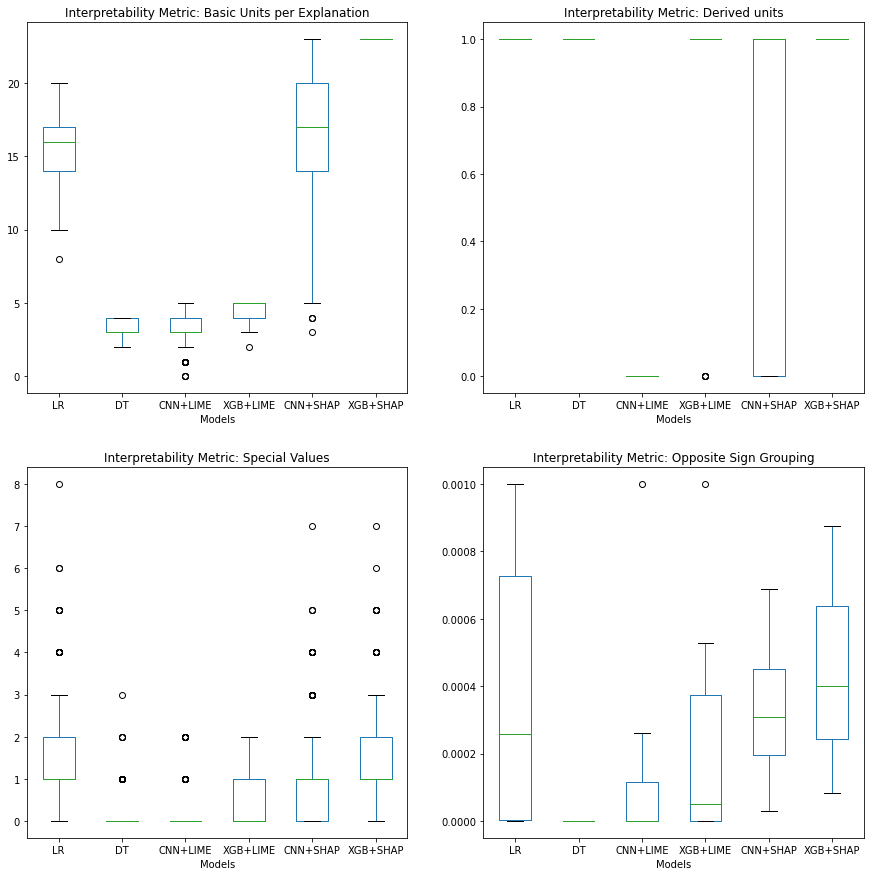

In [122]:
# Se muestran el diagrama de caja para losdatos correspondientes a cada métrica.
figure =plt.gcf()
figure.set_size_inches(15,15)


plt.subplot(221)
# mostramos Unidades básicas por explicación
df_feature.boxplot(figsize=(8,6), grid=False).set(title='Interpretability Metric: Basic Units per Explanation', 
                                      xlabel='Models')

plt.subplot(222)
# mostramos Unidades Derivadas
df_derived.boxplot(figsize=(8,6), grid=False).set(title='Interpretability Metric: Derived units', 
                                      xlabel='Models')

plt.subplot(223)
# Se muestra Valores especiales
df_specialValues.boxplot(figsize=(8,6), grid=False).set(title='Interpretability Metric: Special Values', 
                                      xlabel='Models')

plt.subplot(224)
# Se muestra Agrupaciones con signo opuesto
df_oppositeSignGrouping.boxplot(figsize=(8,6), grid=False).set(title='Interpretability Metric: Opposite Sign Grouping', 
                                      xlabel='Models')


plt.show()